In [29]:
dataverse_path='/Users/jessicasun/Desktop/research files/cones dataverse/data'

Manual preprocessing steps, starting from the raw tif:


1) For each cone, find the latest timepoint past 1 hour (so look in -3.lif or -4.lif)

>This means all time points are collected AT LEAST 70min after solution is injected.

2) Create z projections to get Combined Stacks1, 2, etc.

>If needed, flatten to RGB to prevent intensity changes when combining

4) In each of these Combined Stacks, crop the region for each grain

>Be careful to preserve original dimensions so we can backcalculate pixel to um

>Ctrl a to select entire region. Drag box to desired position. Shift+D to duplicate

7) Save! It will give file called Combined Stacks1-1, 1-2 etc. which represents grains

8) Rename with date_cone#_

>cones default taken with resonant. "tcone" represents cone data from tandem microscope

>note that each date + cone combination results in a unique label

9) Copy the grains into the “all grains” folder
10) Manually update pullparams.xlsx

Initial processing steps:


11) Run processing.ipynb
>load_type='initialize' if want to start new files_df

>load_type='import' if want to import the existing local files_df

>processing_type='auto' if using parameters from files_df

>processing_type='manual' if user input files_df_idx and user input parameters

12) Export as executable, then copy into a new notebook. Modify to allow batch processing

>load_type='initialize' and processing_type='auto'

>use blockPrint()

>enable 'for files_df_idx in range(len(files_df)):' and 'plt.show', and indent the code block

13) Manually evaluate the results of /coneangle

>Save as 'coneangle/bad_...' if need to re-process

>We will search for file names with 'bad_' as prefix to selectively process

Process again:


14) Run processing.ipynb again, this time with load_type='import' and processing_type='manual'

>Modify user input parameters until satisfactory fit

>most grains will be a simple fix (adjusting domain, brightness etc.) but some will be impossible such as unclosed grains that don't touch both sidewalls - that's ok, do your best, we will filter those out later.

>This step will take a few hours... it's more reproducible than doing by hand though so tough it out.

15) Backup a copy of files_df in case we overwrite on accident
16) Export as executable again, then copy into a new notebook. Modify to allow batch processing

>load_type='import' and processing_type='auto', since we are using existing files_df parameters

>use blockPrint()

>enable 'for files_df_idx in range(len(files_df)):' and 'plt.show', and indent the code block

17) Ensure that the cone angle fits look good. Batch process masked images, which will appear in /masked grains.


Apply binary mask to find wc:


18) Manually mask the masked unwrapped images, in /masked grains

>This is where we manually create binary masks from the unwrapped grains - edit the .tif files in this folder. This is way more reliable than doing via image processing due to the changing imaging conditions in each experiment, and grain (boundary) identification is more reliable this way too.

>Use the Analyze -> Tools -> Synchronize Windows option in FIJI.

>Another option is to use Overlay -> Add Image... to save .tif with an overlay layer (can be hidden after). In practice, I used Synchronize Windows as a rough guideline. Then processed / analyzed to create preliminary plots. Then go back in with overlay to refine the mask.

>Especially be careful that the upper and lower edges are properly masked. We crop to the sector bounds once the mask gets reimported so overspill is ok. Just remember our goal is to measure the axial band width using the masks.

>Useful new shortcuts to add to FIJI: (g) Overlay->Add Image...; (u) Hide Overlay; (7) Show Overlay. (Luckily, overlays don't get imported since they're stored in metadata!)

>Top and bottom boundaries should be completely masked - any black pixel area in those regions would mess with finding defects.

>Defects should be masked accurately in the axial direction. Circumferential direction is less crucial, but the thickness of the defects is important in whether or not it gets detected.

>Make sure to mark line slip defects, since those ARE defects even if the edges are touching. Otherwise it makes the definition of a "band" messy, we want to be able to describe it as a continuous defect-free crystalline structure. We can always go back and bin the defects by type later.

19) Batch process again to completion.

>The code is set up so that first we find cone angle, then we find the unwrapped flat images. We use masks from those images to identify crystalline bands in flat space. I have a code block that can do orientation finding but I found that the image quality isn't good enough for center-finding. This is a result of curvature-induced lensing, not my fault. If we index match it might affect the system assembly. The notebook should be able to analyze 100 grains in 10's of minutes. However, adding the binary masking step made the run time ~8 hours or so. I'll fix this .. eventually.

20) Adding data to the dataset

>start from step 1 to prepare data. at step 11, import existing files_df, store as old_df. then initialize a new files_df (which will create new rows with the new files), store as new_df. pd.concat them together with the right rows. use that as files_df up until it exports files_df. then we can start from beginning and import files_df and analyze as usual.

***note: all angles are in degrees unless specified otherwise

In [30]:
import sys
import numpy as np
import pandas as pd
import os
import trackpy as tp
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib import cm
from skimage import io, exposure
from skimage.filters import threshold_otsu, threshold_multiotsu, try_all_threshold, threshold_local
from skimage.morphology import skeletonize, convex_hull_image
from skimage.measure import label, regionprops_table
from skimage.color import rgb2gray, gray2rgb
from scipy.ndimage import binary_opening, binary_closing, binary_erosion, binary_dilation, rotate, gaussian_filter
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats import circmean
from scipy.interpolate import griddata

In [49]:
# def blockPrint():
#     sys.stdout = open(os.devnull, 'w')
# def enablePrint():
#     sys.stdout = sys.__stdout__
# blockPrint()
# #enablePrint()

In [33]:
dir_path=dataverse_path+'/'

print('initialize or import files_df from \n'+dir_path+'\n')
# load_type='initialize' #initialize new files_df
load_type='import' #import existing files_df

print(load_type)

initialize or import files_df from 
/Users/jessicasun/Desktop/research files/cones dataverse/data/

import


In [34]:
if load_type=='initialize':
    print('load files from /all grains\n')
    file_name_list=[]
    temp=os.listdir(dir_path+'all grains/')
    temp.sort()
    for file_name in temp:
        if file_name.endswith('.tif'):
            file_name_list+=[file_name]
    files_df=pd.DataFrame({'file_name':file_name_list})
    files_df=pd.DataFrame({'file_name':file_name_list,
                           'date':files_df['file_name'].str.split('_',expand=True)[0],
                          'cone':files_df['file_name'].str.split('_',expand=True)[1]})
    files_df['file_path']=dir_path+'all grains/'
    files_df['file_path']=files_df['file_path']+files_df['file_name']

    print('load pullparams.xlsx\n')
    pullparams_df=pd.read_excel(dir_path+'/pullparams.xlsx',dtype='str')
    pullparams_df.head()
    files_df=pd.merge(pullparams_df,files_df,on=['date','cone'])

    print('initialize data columns\n') #easier to filter out a placeholder number than nan
    files_df['coneangle']=-100   
    files_df['line1angle']=-100
    files_df['line2angle']=-100
    files_df['line1slope']=-100
    files_df['line2slope']=-100
    files_df['line1intercept']=-100
    files_df['line2intercept']=-100
    files_df['top_ij_angle_avg']=-100  
    files_df['bot_ij_angle_avg']=-100
    files_df['im_top_multiplier_1']=1
    files_df['im_top_multiplier_2']=1   
    files_df['im_bot_multiplier_1']=1
    files_df['im_bot_multiplier_2']=1       
    files_df['im_binary_o']=10
    files_df['im_binary_c']=10     
    files_df['im_bright_exp']=3
    files_df['im_bright_h']=10
    files_df['im_bright_v']=5 
    files_df['im_bright_1']=1
    files_df['im_bright_2']=1     
    files_df['side1_l']=0
    files_df['side1_r']=1    
    files_df['side2_l']=0
    files_df['side2_r']=1
    files_df['sectorangle']=-100
    files_df['circ_min']=-100
    files_df['circ_max']=-100
    files_df['sectorR_min']=-100
    files_df['sectorR_max']=-100
    files_df['origin_x']=-100
    files_df['origin_y']=-100
    files_df['band_label_cut']=-100
    files_df['band_width']=-100
    files_df['band_sectorR_min']=-100
    files_df['band_sectorR_max']=-100
    files_df['band_sectorR_0']=-100
    files_df['band_area']=-100
    files_df['band_area_ref']=-100
    files_df['band_circ_0']=-100
    files_df['band_diam_0']=-100
if load_type=='import':
    files_df=pd.read_pickle(dir_path+'files_df.pkl')    
    files_df['file_path']=dir_path+'all grains/'+files_df['file_name'] #reset path column if dir has changed
files_df

date    cone              pullparams  \
0    071923   cone1  tw120_h448_p40_v20_t40   
1    071923   cone1  tw120_h448_p40_v20_t40   
2    071923   cone1  tw120_h448_p40_v20_t40   
3    071923   cone1  tw120_h448_p40_v20_t40   
4    071923   cone1  tw120_h448_p40_v20_t40   
..      ...     ...                     ...   
121  082923   cone2  tw150_h473_p40_v35_t40   
122  082923   cone3  tw150_h473_p40_v31_t40   
123  082923   cone3  tw150_h473_p40_v31_t40   
124  082923   cone3  tw150_h473_p40_v31_t40   
125  082923  tcone1  tw150_h473_p40_v33_t40   

                                file_name  \
0     071923_cone1_Combined Stacks1-1.tif   
1     071923_cone1_Combined Stacks2-1.tif   
2     071923_cone1_Combined Stacks2-2.tif   
3     071923_cone1_Combined Stacks3-1.tif   
4     071923_cone1_Combined Stacks3-2.tif   
..                                    ...   
121   082923_cone2_Combined Stacks1-1.tif   
122   082923_cone3_Combined Stacks1-1.tif   
123   082923_cone3_Combined Stacks2-1.tif   
124   082923_cone3_Combined Stacks3-1.tif   
125  082923_tcone1_Combined Stacks1-1.tif   

                                             file_path  coneangle  line1angle  \
0    /Users/jessicasun/Desktop/research files/cones...   0.665875    1.319203   
1    /Users/jessicasun/Desktop/research files/cones...  -0.793062    0.966356   
2    /Users/jessicasun/Desktop/research files/cones...   1.340747    1.452597   
3    /Users/jessicasun/Desktop/research files/cones...   0.750500    0.946716   
4    /Users/jessicasun/Desktop/research files/cones...   0.341103    1.107522   
..                                                 ...        ...         ...   
121  /Users/jessicasun/Desktop/research files/cones...   3.143785    2.902502   
122  /Users/jessicasun/Desktop/research files/cones...   3.054975    2.021519   
123  /Users/jessicasun/Desktop/research files/cones...   1.960751    1.468795   
124  /Users/jessicasun/Desktop/research files/cones...   1.183723    1.208224   
125  /Users/jessicasun/Desktop/research files/cones...   4.211922    2.692771   

     line2angle  line1slope  line2slope  ...  origin_y  band_width  \
0      0.653328    0.023029    0.011403  ...      -0.0       146.0   
1      1.759418    0.016868    0.030717  ...      -0.0       247.0   
2      0.111850    0.025358    0.001952  ...      -0.0        63.0   
3      0.196216    0.016525    0.003425  ...      -0.0       106.0   
4      0.766419    0.019332    0.013377  ...      -0.0       133.0   
..          ...         ...         ...  ...       ...         ...   
121   -0.241283    0.050702   -0.004211  ...      -0.0        31.0   
122   -1.033456    0.035297   -0.018039  ...      -0.0        41.0   
123   -0.491956    0.025641   -0.008586  ...      -0.0        44.0   
124    0.024501    0.021091    0.000428  ...      -0.0        34.0   
125   -1.519151    0.047032   -0.026520  ...      -0.0        44.0   

     band_sectorR_min  band_sectorR_max  band_sectorR_0  band_area  \
0         5308.412381       5454.412381     5381.412381    86128.0   
1         4138.001102       4385.001102     4261.501102   137432.0   
2         2476.702970       2539.702970     2508.202970    34876.0   
3         5015.719495       5121.719495     5068.719495    66383.0   
4        10973.045383      11106.045383    11039.545383    82446.0   
..                ...               ...             ...        ...   
121       2374.443861       2405.443861     2389.943861    38320.0   
122       1992.000349       2033.000349     2012.500349    41462.0   
123       3688.966335       3732.966335     3710.966335    52690.0   
124       6906.913334       6940.913334     6923.913334    45852.0   
125       1063.101204       1107.101204     1085.101204    33089.0   

     band_area_ref  band_circ_0  band_diam_0  band_label_cut  
0          86128.0   196.478045    62.540904             NaN  
1         137433.0   185.307678    58.985266             NaN  
2          34876.0   184.385483    58.691722             

use existing values from files_df
/Users/jessicasun/Desktop/research files/cones dataverse/data/all grains/080723_cone3_Combined Stacks1-1.tif

split image planes to balance displayed intensity
get cone angle by taking z-projection. we assume that the cone axis is parallel to detector plane

process binary to get rid of stray particles
find bright pixels that represent sidewalls
horizontally erode and vertically dilate to create mask from im_bright
additional directional erosion towards outer edges if needed
dilate im_binary then subtract eroded binary to get an outline

filter im_line with im_bright

if im_brightline is (near-)empty, use im_line to find sidewalls instead
use im_line, not im_brightline, to find midline
convert im_brightline to point coordinates

split xy_coords into two sets of lines for top and bottom sidewall
check to make sure there are enough points for line fit
apply left and right extents to crop side1_coords and side2_coords
fit line and find angles
save for val

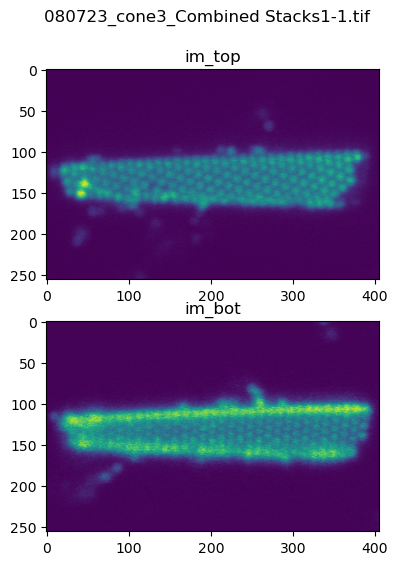

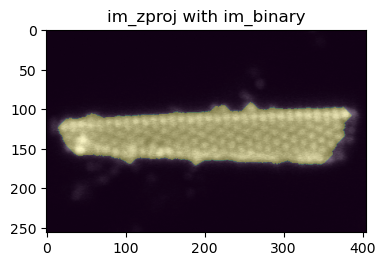

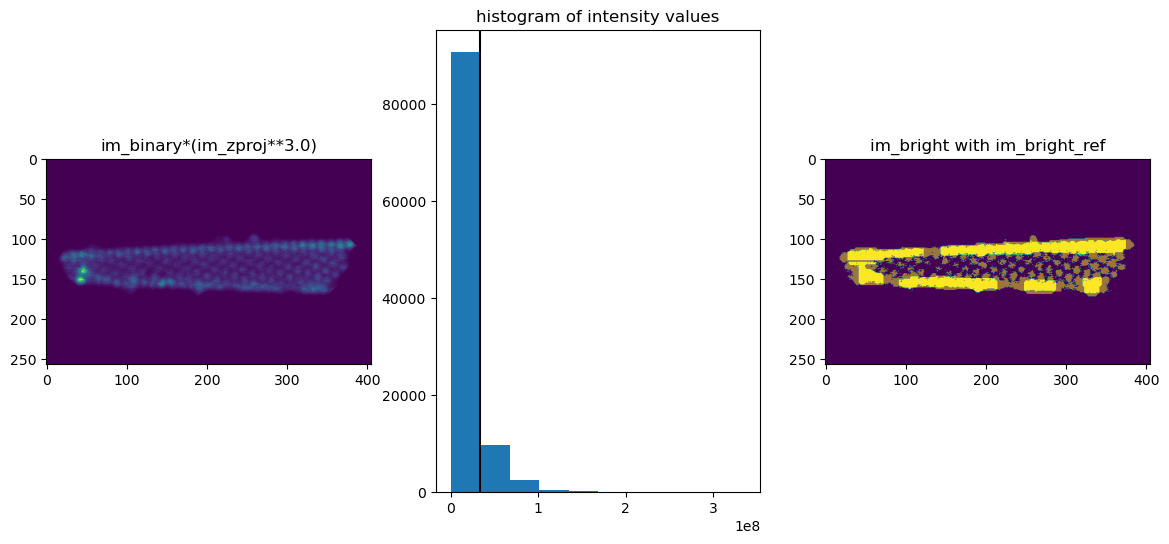

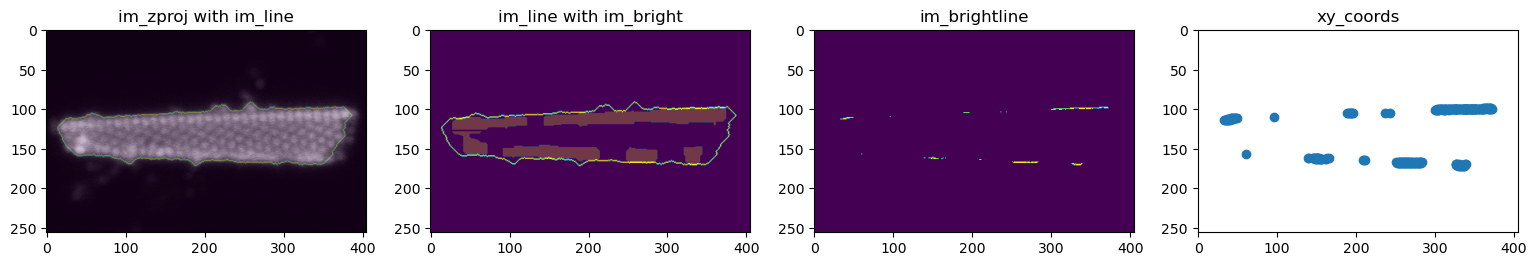

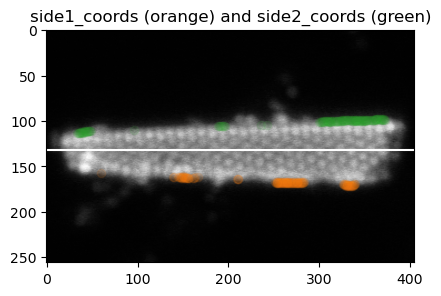

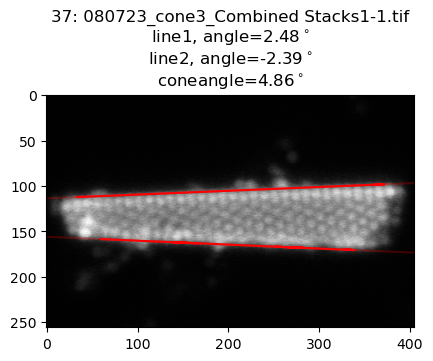


export files_df to store data info


date   cone              pullparams  \
37  080723  cone3  tw100_h453_p45_v30_t10   

                              file_name  \
37  080723_cone3_Combined Stacks1-1.tif   

                                            file_path  coneangle  line1angle  \
37  /Users/jessicasun/Desktop/research files/cones...   4.864348    2.477704   

    line2angle  line1slope  line2slope  ...  origin_y  band_width  \
37   -2.386644    0.043271   -0.041679  ...      -0.0        68.0   

    band_sectorR_min  band_sectorR_max  band_sectorR_0  band_area  \
37        539.622147        607.622147      573.622147    31202.0   

    band_area_ref  band_circ_0  band_diam_0  band_label_cut  
37        31234.0   152.949234    48.685253             NaN  

[1 rows x 45 columns]

In [35]:
# process_type='manual'
process_type='auto'

# overwrite_mask=True #overwrite existing files in /masked grains. make sure you backup processed images before proceeding
overwrite_mask=False #dont overwrite masked files. use existing. it will write a new mask file if doesnt already exist though.

files_df_idx=37
# for files_df_idx in range(len(files_df)):
# plt.show()

if process_type=='auto':
    print('use existing values from files_df')
    im_top_multiplier_1=files_df.iloc[files_df_idx]['im_top_multiplier_1']
    im_top_multiplier_2=files_df.iloc[files_df_idx]['im_top_multiplier_2']
    im_bot_multiplier_1=files_df.iloc[files_df_idx]['im_bot_multiplier_1']    
    im_bot_multiplier_2=files_df.iloc[files_df_idx]['im_bot_multiplier_2']
    im_binary_o=files_df.iloc[files_df_idx]['im_binary_o']
    im_binary_c=files_df.iloc[files_df_idx]['im_binary_c']    
    im_bright_exp=files_df.iloc[files_df_idx]['im_bright_exp']
    im_bright_h=files_df.iloc[files_df_idx]['im_bright_h']
    im_bright_v=files_df.iloc[files_df_idx]['im_bright_v']    
    im_bright_1=files_df.iloc[files_df_idx]['im_bright_1']
    im_bright_2=files_df.iloc[files_df_idx]['im_bright_2']        
    side1_l=files_df.iloc[files_df_idx]['side1_l']
    side1_r=files_df.iloc[files_df_idx]['side1_r']    
    side2_l=files_df.iloc[files_df_idx]['side2_l']
    side2_r=files_df.iloc[files_df_idx]['side2_r']
if process_type=='manual':
    print('set user input values for files_df')
    if not os.path.exists(dir_path+'/all grains/coneangle'):
        os.mkdir(dir_path+'/all grains/coneangle')    
    bad=os.listdir(dir_path+'all grains/coneangle/')
    bad_list=[]
    for bad_file in bad:
        if bad_file.startswith('bad_'): #these files are manually renamed to indicate that reprocessing is needed
            bad_idx=int(bad_file.split('_')[1])
            bad_list+=[bad_idx]
    bad_list.sort()

    print('import and display image (assumes y dimensions of 512 pixels)\n')
    files_df_idx=int(input('select from'+str(range(len(files_df)))+' or bad_list:'+str(bad_list)))
    
    print('default values: 1.0 1.0 1.0 1.0     10 10 3.0 10 5     1 1     0.0 1.0 0.0 1.0')
    im_top_multiplier_1=float(input('im_top_multiplier_1, enhance brightness (default=1):')) #bottom half of im_top image (because images are origin from top left)
    im_top_multiplier_2=float(input('im_top_multiplier_2, enhance brightness (default=1):')) #top half of im_top image (because images are origin from top left)
    im_bot_multiplier_1=float(input('im_bot_multiplier_1, enhance brightness (default=1):')) #change the multipliers when emphasizing or deemphasizing bright regions of interest    
    im_bot_multiplier_2=float(input('im_bot_multiplier_2, enhance brightness (default=1):'))
    im_binary_o=int(input('\nim_binary_o, remove strays (default=10):')) #binary opening gets rid of small dots. however, adjust this if it's getting rid of important features
    im_binary_c=int(input('im_binary_c, close holes (default=10):')) #closes holes
    im_bright_exp=float(input('im_bright_exp, exponent value (default=3):')) #nonlinear contrast change - decrease if need to get wider range of brightness values. increase if want to select bright spots
    im_bright_h=int(input('im_bright_h, horizontal erosion iterations (default=10):')) #for auto this is good to get rid of edge effects. but, for manual it might be too strict.
    im_bright_v=int(input('im_bright_v, vertical dilation iterations (default=5):')) #this value ensures that im_bright overlaps with im_line at desirable regions
    im_bright_1=int(input('\nim_bright_1, vertical outer erosion iterations (default=1):')) #if im_bright dilation ends up selecting inner features, apply directional erosion
    im_bright_2=int(input('im_bright_2, vertical outer erosion iterations (default=1):')) #_1 represents BOTTOM half, _2 represents TOP half (_1 and _2 naming convention was based off of coordinates, not images)
    side1_l=float(input('\nside1_l, left extent (default=0)')) #crop bottom line
    side1_r=float(input('side1_r, right extent (default=1)'))
    side2_l=float(input('side2_l, left extent (default=0)')) #crop top line
    side2_r=float(input('side2_r, right extent (default=1)'))
    print('\n\n',files_df_idx,': ',
          im_top_multiplier_1,im_top_multiplier_2,im_bot_multiplier_1,im_bot_multiplier_2,'   ',
         im_binary_o, im_binary_c,im_bright_exp,im_bright_h,im_bright_v,'   ',
         im_bright_1,im_bright_2,'   ',
         side1_l,side1_r,side2_l,side2_r,'<<<copy and paste this as reference!!!!/n/n')
print(files_df.iloc[files_df_idx]['file_path']+'\n')
im = io.imread(files_df.iloc[files_df_idx]['file_path']) #plt.imread struggles with 32-bit files, use skimage instead

if np.shape(im)[0]<=2: #if multi-channel data... (if single channel image, the first number would be 512)
    im=im[0] #only take first channel
if len(np.shape(im))>2: #if image is RGB or RGBA
    im=rgb2gray(im) #convert to greyscale
    
im_top=im[:int(512/2)]
im_bot=im[int(512/2):]

figsize_dim=(6*np.shape(im)[1]/np.shape(im)[0],6)
fig=plt.figure(figsize=figsize_dim)
fig.suptitle(files_df.iloc[files_df_idx]['file_name'])
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

print('split image planes to balance displayed intensity')
ax1.imshow(im_top)
ax2.imshow(im_bot)
ax1.set_title('im_top')
ax2.set_title('im_bot')

print('get cone angle by taking z-projection. we assume that the cone axis is parallel to detector plane\n')
#in the past, i did 3d reconstruction using xyz coordinates, then took vertical slices, ellipse fitting to find the centroid etc. but it's not worth the effort for amount of error that gets introduced. lensing makes reconstruction difficult

#to get binary image, selectively enhance brightness values if needed to help with feature finding later (default=1)
ydim=int(np.shape(im_top)[0]/2)
im_top_multiplied=im_top #initialize
im_top_multiplied[:ydim,:]=im_top[:ydim,:]*im_top_multiplier_2
im_top_multiplied[ydim:,:]=im_top[ydim:,:]*im_top_multiplier_1

im_bot_multiplied=im_bot #initialize
im_bot_multiplied[:ydim,:]=im_bot[:ydim,:]*im_bot_multiplier_2
im_bot_multiplied[ydim:,:]=im_bot[ydim:,:]*im_bot_multiplier_1

im_zproj=(im_top_multiplied+im_bot_multiplied)/2
im_otsu=threshold_otsu(im_zproj)
im_binary=im_zproj>im_otsu

print('process binary to get rid of stray particles')
im_binary=binary_opening(im_binary, iterations=im_binary_o)
im_binary=binary_closing(im_binary, iterations=im_binary_c)

fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]))
ax=fig.add_subplot(141)
ax.imshow(im_zproj,cmap='Greys_r')
ax.imshow(im_binary,alpha=0.25)
ax.set_title('im_zproj with im_binary')

print('find bright pixels that represent sidewalls')

im_bright=im_binary*(im_zproj**im_bright_exp) #make brights brighter
fig=plt.figure(figsize=(figsize_dim[0]*3,figsize_dim[1]))
ax=fig.add_subplot(131)
ax.imshow(im_bright)
ax.set_title('im_binary*(im_zproj**'+str(im_bright_exp)+')')
ax=fig.add_subplot(132)
n_bright,bins_bright,_=ax.hist(np.ndarray.flatten(im_bright))
bright_df=pd.DataFrame([])
bright_df['bins_bright']=bins_bright[1:]
bright_df['n_bright']=n_bright
maxval=bright_df[bright_df['n_bright']==np.max(bright_df['n_bright'])]['bins_bright'].values[0]
ax.axvline(maxval,color='black')
ax.set_title('histogram of intensity values')

print('horizontally erode and vertically dilate to create mask from im_bright')
im_bright=(im_bright)>maxval
im_bright_ref=im_bright
im_bright=binary_opening(im_bright,iterations=5)
im_bright=binary_erosion(im_bright,structure=np.array([[0,0,0],[1,1,1],[0,0,0]]),iterations=im_bright_h) #erode horizontally to get rid of edge artifacts
im_bright=binary_dilation(im_bright,structure=np.array([[0,1,0],[0,1,0],[0,1,0]]),iterations=im_bright_v) #dilate in vertical direction to ensure mask overlaps with im_line later

print('additional directional erosion towards outer edges if needed')
ydim=int(np.shape(im_binary)[0]/2)
im_bright[:ydim,:]=binary_erosion(im_bright[:ydim,:],structure=np.array([[0,0,0],[0,1,0],[0,1,0]]),iterations=im_bright_2) #erode vertically towards upper edge (lower y)
im_bright[ydim:,:]=binary_erosion(im_bright[ydim:,:],structure=np.array([[0,1,0],[0,1,0],[0,0,0]]),iterations=im_bright_1) #erode vertically towards lower edge (higher y)
ax=fig.add_subplot(133)
ax.imshow(im_bright)
ax.imshow(im_bright_ref,alpha=0.5)
ax.set_title('im_bright with im_bright_ref')

print('dilate im_binary then subtract eroded binary to get an outline\n')
im_line=1*binary_dilation(im_binary)-1*binary_erosion(im_binary)

fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]))
ax=fig.add_subplot(141)
ax.imshow(im_zproj,cmap='Greys_r')
ax.imshow(im_line,alpha=0.25)
ax.set_title('im_zproj with im_line')

ax=fig.add_subplot(142)
ax.imshow(im_line,alpha=1)
ax.imshow(im_bright,alpha=0.25)
ax.set_title('im_line with im_bright')

print('filter im_line with im_bright\n')
ax=fig.add_subplot(143)
im_brightline=im_bright*im_line
ax.imshow(im_brightline)
ax.set_title('im_brightline')

print('if im_brightline is (near-)empty, use im_line to find sidewalls instead')
if np.sum(im_brightline)<=10:
    im_brightline=binary_erosion(im_line,structure=np.array([[0,0,0],[1,1,1],[0,0,0]]),iterations=5) #replace with horizontally eroded im_line
    ax.imshow(im_brightline)
    ax.set_title('im_brightline, binary_erosion iterations=5')
if np.sum(im_brightline)<=10:
    im_brightline=binary_erosion(im_line,structure=np.array([[0,0,0],[1,1,1],[0,0,0]]),iterations=3) #replace with horizontally eroded im_line
    ax.imshow(im_brightline)
    ax.set_title('im_brightline, binary_erosion iterations=3')

print('use im_line, not im_brightline, to find midline')
yx_coords = np.column_stack(np.where(im_line > 0))
xy_coords = np.flip(np.column_stack(np.where(im_line > 0)), axis=1)
# xy_coords[:,1]=min(xy_coords[:,1])+(max(xy_coords[:,1])-xy_coords[:,1]) #invert y-axis (since image data is flipped coordinates)
xy_coords=pd.DataFrame({'x':xy_coords[:,0],'y':xy_coords[:,1]})
midline=(max(xy_coords['y'])+min(xy_coords['y']))/2

print('convert im_brightline to point coordinates\n')
yx_coords = np.column_stack(np.where(im_brightline > 0))
xy_coords = np.flip(np.column_stack(np.where(im_brightline > 0)), axis=1)
# xy_coords[:,1]=min(xy_coords[:,1])+(max(xy_coords[:,1])-xy_coords[:,1]) #invert y-axis (since image data is flipped coordinates)
xy_coords=pd.DataFrame({'x':xy_coords[:,0],'y':xy_coords[:,1]})

ax=fig.add_subplot(144)
ax.imshow(im_zproj,cmap='Greys_r',alpha=0) #transparent image to set plot coordinates
ax.scatter(xy_coords['x'],xy_coords['y'])
ax.set_aspect('equal')
ax.set_title('xy_coords')

print('split xy_coords into two sets of lines for top and bottom sidewall')
side1_coords=xy_coords[xy_coords['y']>=midline]
side2_coords=xy_coords[xy_coords['y']<midline]

print('check to make sure there are enough points for line fit')
if (len(side1_coords)<=4)|(len(side2_coords)<=4):
    im_brightline=binary_erosion(im_line,structure=np.array([[0,0,0],[1,1,1],[0,0,0]]),iterations=1) #replace with horizontally eroded im_line  - use lowered iterations every time there aren't enough points
    yx_coords = np.column_stack(np.where(im_brightline > 0))
    xy_coords = np.flip(np.column_stack(np.where(im_brightline > 0)), axis=1)
    xy_coords=pd.DataFrame({'x':xy_coords[:,0],'y':xy_coords[:,1]})        
    midline=(max(xy_coords['y'])+min(xy_coords['y']))/2
    side1_coords=xy_coords[xy_coords['y']>=midline]
    side2_coords=xy_coords[xy_coords['y']<midline]

print('apply left and right extents to crop side1_coords and side2_coords')
xdim=np.shape(im_zproj)[1]
side1_coords=side1_coords[(side1_coords['x']>=(side1_l*xdim))&(side1_coords['x']<=(side1_r*xdim))] #default should be [0,1]*xdim
side2_coords=side2_coords[(side2_coords['x']>=(side2_l*xdim))&(side2_coords['x']<=(side2_r*xdim))] #adjust to trim

fig=plt.figure(figsize=(figsize_dim[0],figsize_dim[1]))
ax=fig.add_subplot(111)
ax.imshow(im_zproj,cmap='Greys_r')
ax.scatter(side1_coords['x'],side1_coords['y'],alpha=0.1,c='C1')
ax.scatter(side2_coords['x'],side2_coords['y'],alpha=0.1,c='C2')
ax.set_title('side1_coords (orange) and side2_coords (green)')
ax.axhline(midline,color='w')

print('fit line and find angles')

line1_df=pd.DataFrame({'x':side1_coords['x']})
line1_df['slope'],line1_df['intercept'],line1_df['rvalue'],line1_df['pvalue'],line1_df['intercept_stderr']=stats.linregress(side1_coords['x'],side1_coords['y']) #line of best fit
line1_df['angle'] = np.arctan(line1_df['slope'])*180/np.pi
line1_df['y']=line1_df['intercept']+line1_df['slope'].multiply(line1_df['x']) #y values based on fit parameters

line2_df=pd.DataFrame({'x':side2_coords['x']})
line2_df['slope'],line2_df['intercept'],line2_df['rvalue'],line2_df['pvalue'],line2_df['intercept_stderr']=stats.linregress(side2_coords['x'],side2_coords['y']) #line of best fit
line2_df['angle'] = np.arctan(line2_df['slope'])*180/np.pi
line2_df['y']=line2_df['intercept']+line2_df['slope'].multiply(line2_df['x']) #y values based on fit parameters

# coneangle=np.abs(np.unique(line1_df['angle'])[0]-np.unique(line2_df['angle'])[0])
coneangle=np.unique(line1_df['angle'])[0]-np.unique(line2_df['angle'])[0]

fig=plt.figure(figsize=(figsize_dim[0]*1,figsize_dim[1]))
ax=fig.add_subplot(111)

ax.imshow(im_zproj,cmap='Greys_r')
ax.plot(line1_df['x'], line1_df['y'], 'r')
ax.plot(line2_df['x'], line2_df['y'], 'r')

#reference lines
xref=np.arange(0,xdim,1)
ax.plot(xref, line1_df['slope'].values[0]*xref+line1_df['intercept'].values[0], 'r',alpha=0.25)
ax.plot(xref, line2_df['slope'].values[0]*xref+line2_df['intercept'].values[0], 'r',alpha=0.25)

ax.set_aspect('equal')
ax.set_title(str(files_df_idx)+': '+files_df['file_name'].iloc[files_df_idx]+'\n'+
             'line1, angle='+str(round(np.unique(line1_df['angle'])[0],2))+r'$^\circ$'+'\n'+
            'line2, angle='+str(round(np.unique(line2_df['angle'])[0],2))+r'$^\circ$'+'\n'+
            'coneangle='+str(round(coneangle,2))+r'$^\circ$')
print('save for validation')
if not os.path.exists(dir_path+'/all grains/coneangle'):
    os.mkdir(dir_path+'/all grains/coneangle')
im_path=dir_path+'/all grains/coneangle/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
plt.savefig(im_path)
plt.show()

files_df.at[files_df_idx,'coneangle']=coneangle
files_df.at[files_df_idx,'line1angle']=np.unique(line1_df['angle'])[0]
files_df.at[files_df_idx,'line2angle']=np.unique(line2_df['angle'])[0]
files_df.at[files_df_idx,'line1slope']=np.unique(line1_df['slope'])[0]
files_df.at[files_df_idx,'line2slope']=np.unique(line2_df['slope'])[0]
files_df.at[files_df_idx,'line1intercept']=np.unique(line1_df['intercept'])[0]
files_df.at[files_df_idx,'line2intercept']=np.unique(line2_df['intercept'])[0]
files_df.at[files_df_idx,'im_top_multiplier_1']=im_top_multiplier_1
files_df.at[files_df_idx,'im_top_multiplier_2']=im_top_multiplier_2
files_df.at[files_df_idx,'im_bot_multiplier_1']=im_bot_multiplier_1
files_df.at[files_df_idx,'im_bot_multiplier_2']=im_bot_multiplier_2
files_df.at[files_df_idx,'im_binary_o']=im_binary_o
files_df.at[files_df_idx,'im_binary_c']=im_binary_c
files_df.at[files_df_idx,'im_bright_exp']=im_bright_exp
files_df.at[files_df_idx,'im_bright_h']=im_bright_h
files_df.at[files_df_idx,'im_bright_v']=im_bright_v
files_df.at[files_df_idx,'im_bright_1']=im_bright_1
files_df.at[files_df_idx,'im_bright_2']=im_bright_2
files_df.at[files_df_idx,'side1_l']=side1_l
files_df.at[files_df_idx,'side1_r']=side1_r
files_df.at[files_df_idx,'side2_l']=side2_l
files_df.at[files_df_idx,'side2_r']=side2_r

print('\nexport files_df to store data info')
files_df.to_pickle(dir_path+'files_df.pkl');
files_df.to_excel(dir_path+'/files_df.xlsx')

files_df.iloc[[files_df_idx]]

rotate image so that we can find circumferential values as vertical sections
find horizontal and vertical midlines to act as reference
rotate parameters so that we can take vertical sections to represent diameter
generate 3D cone surface by fitting circular sections along cone axis

interpolate 3D cone surface to get 2D grid with z values

map 2D image values onto 3D surface
put the two halves of the 3D cone into a single dataset
rotate and center 3D cone axis so that we can find polar coords
convert cartesian (x,y,z) to cylindrical coordinates (radius,sectorR,phi) where phi is azimuthal angle.
plot 3D data as 2D sector
2D sector with periodic images
interpolate irregular point data into evenly-spaced image data
locate grains manually using ImageJ, in /masked grains
repeat the process to get binary image, with top and bottom thresholded separately
map 2D image values onto 3D surface
put the two halves of the 3D cone into a single dataset
rotate and center 3D cone axis so that we can fi

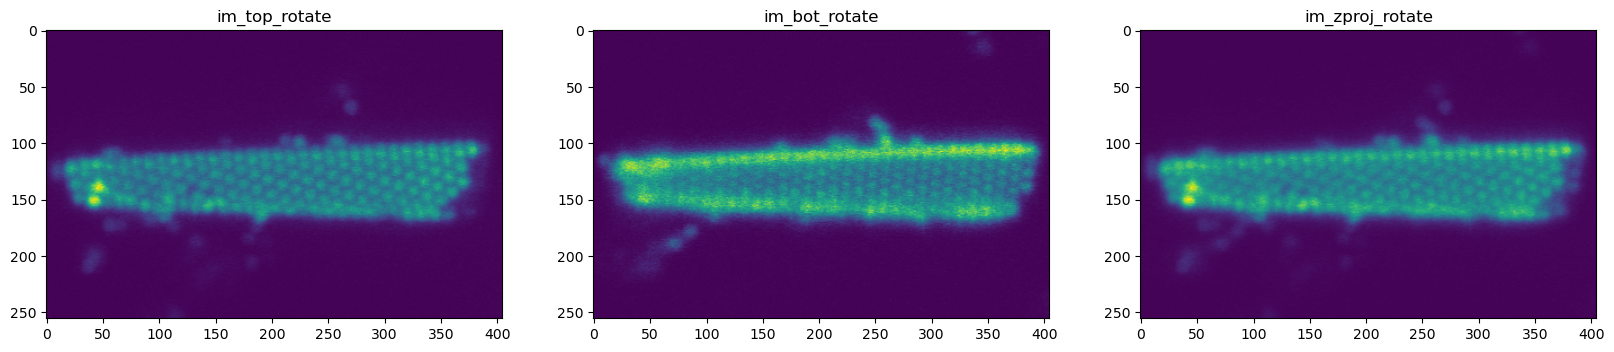

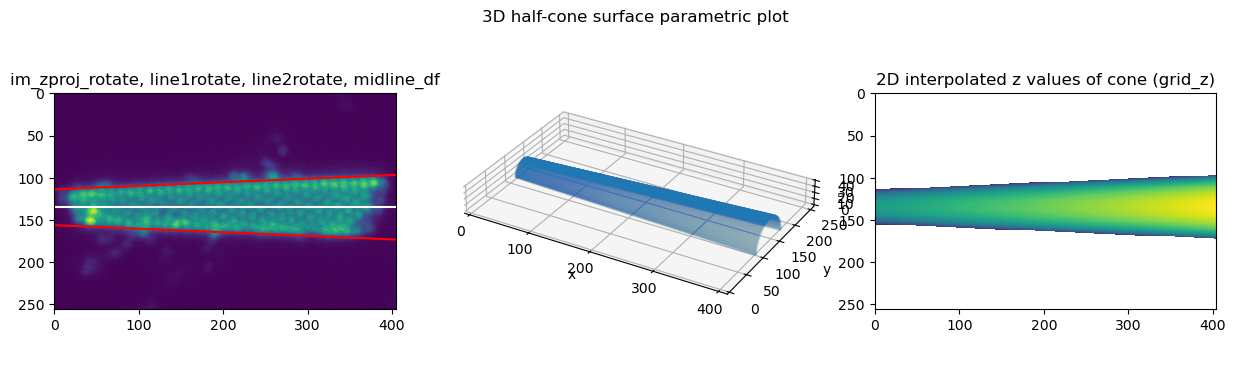

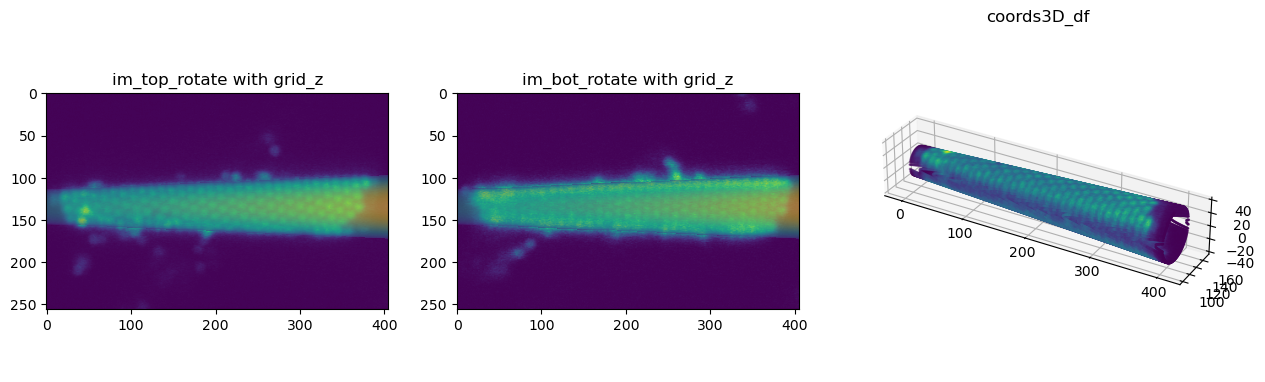

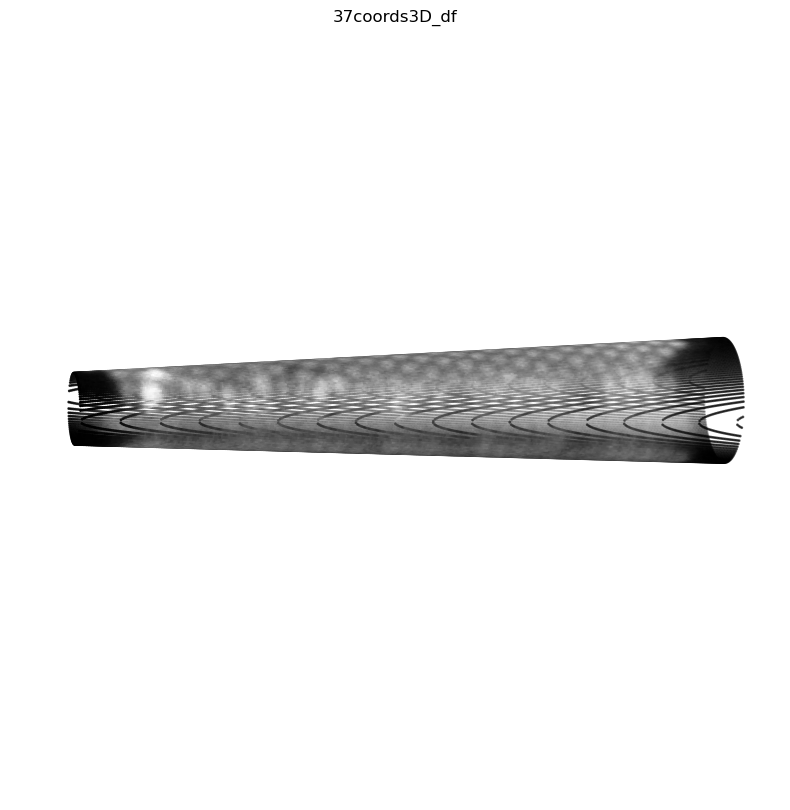

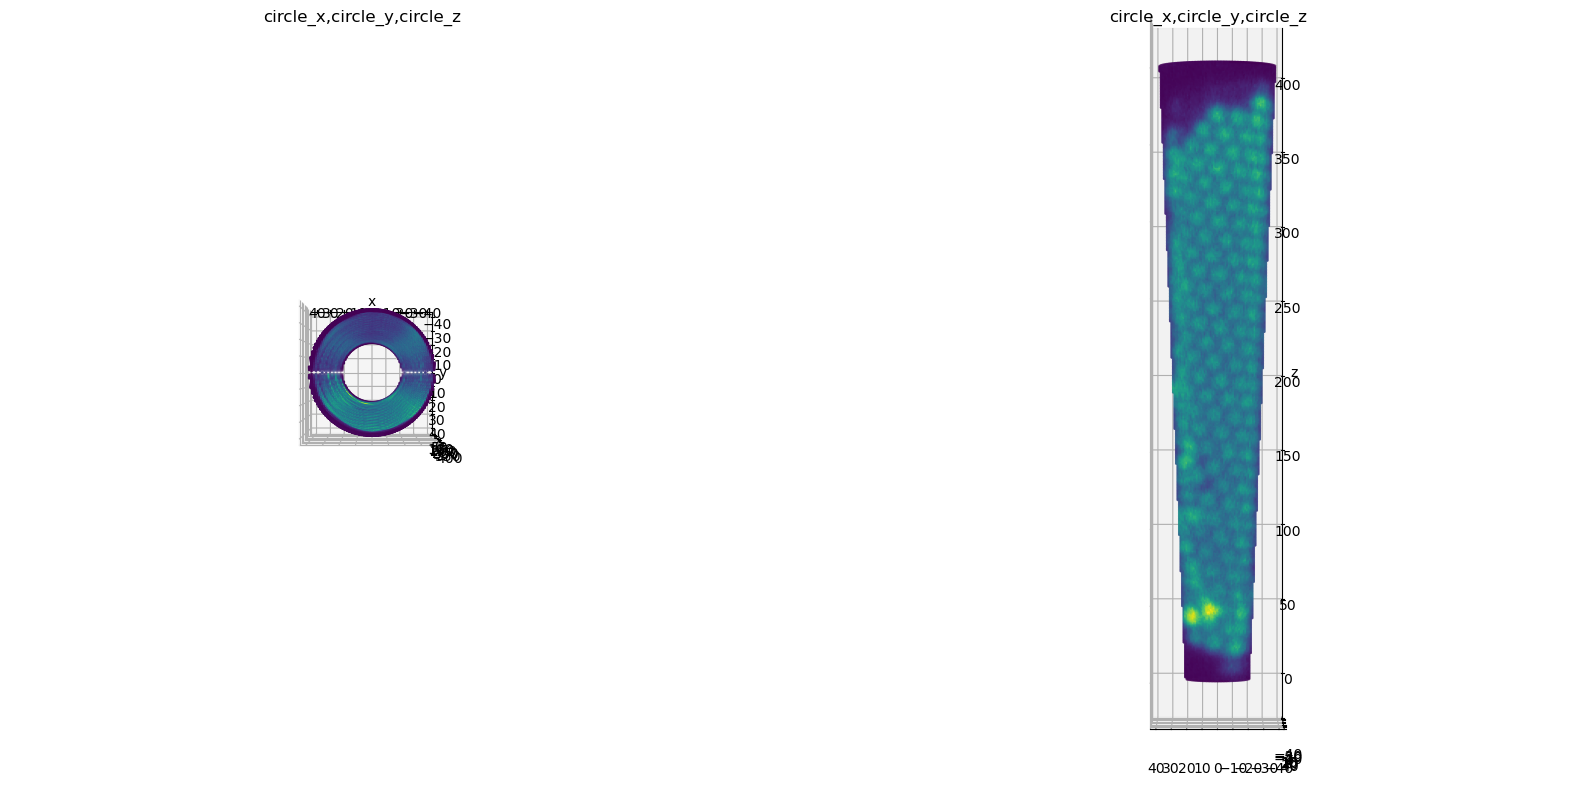

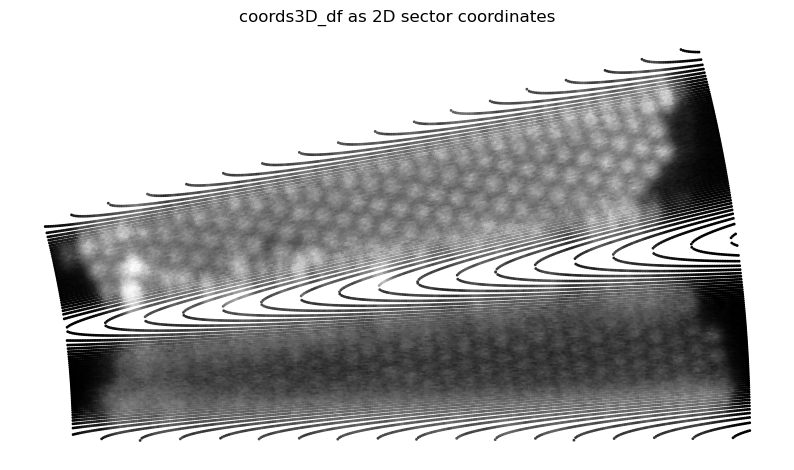

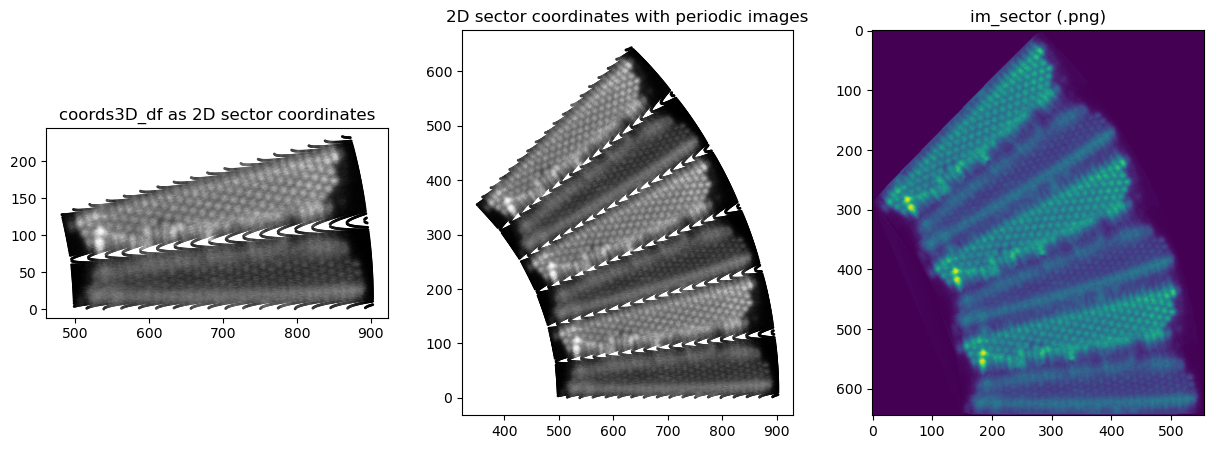

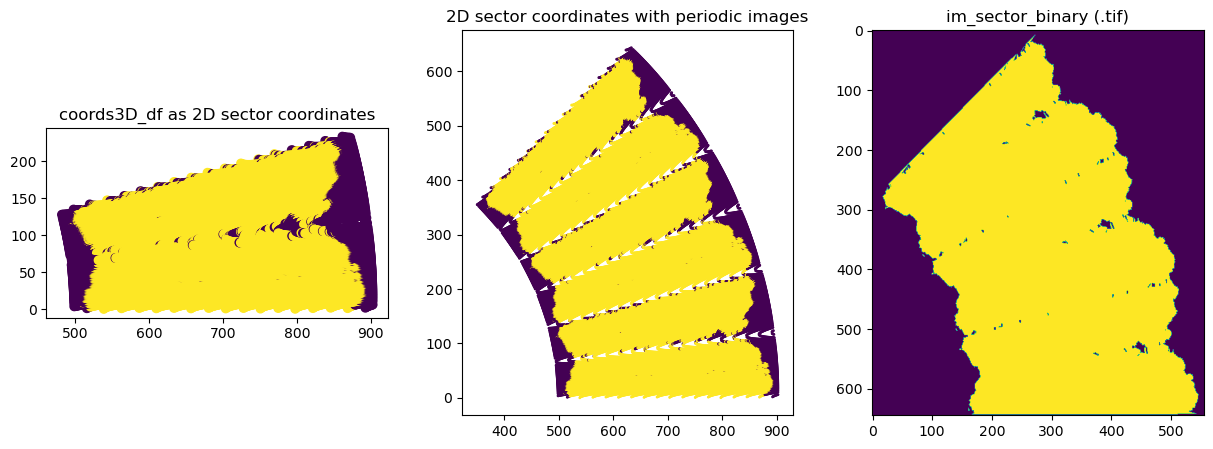

In [38]:
print('rotate image so that we can find circumferential values as vertical sections')
line1angle=files_df['line1angle'].iloc[files_df_idx]
line2angle=files_df['line2angle'].iloc[files_df_idx]
coneangle=files_df['coneangle'].iloc[files_df_idx]

halfangle=coneangle/2 #note: angles are positive CLOCKWISE because images are imported upside down
rotangle=-(halfangle-line1angle)

im_top_rotate=rotate(im_top,rotangle,reshape=False)
im_bot_rotate=rotate(im_bot,rotangle,reshape=False)

fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(131)
ax.imshow(im_top_rotate)
ax.set_title('im_top_rotate')
ax=fig.add_subplot(132)
ax.imshow(im_bot_rotate)
ax.set_title('im_bot_rotate')

print('find horizontal and vertical midlines to act as reference')
ax=fig.add_subplot(133)
im_zproj_rotate=im_top_rotate+im_bot_rotate
ax.imshow(im_zproj_rotate)
ax.set_title('im_zproj_rotate')

print('rotate parameters so that we can take vertical sections to represent diameter')
def rotate_coord(ref,point, angle): #angle in deg
    y, x = ref 
    ox, oy = (x/2,y/2) #to match ndimage.rotate
    px, py = point
    qx = ox + np.cos(np.deg2rad(angle)) * (px - ox) - np.sin(np.deg2rad(angle)) * (py - oy)
    qy = oy + np.sin(np.deg2rad(angle)) * (px - ox) + np.cos(np.deg2rad(angle)) * (py - oy)
    return qx, qy


line1slope=files_df['line1slope'].iloc[files_df_idx]
line1intercept=files_df['line1intercept'].iloc[files_df_idx]
line1_df=pd.DataFrame({'x':np.arange(0,np.shape(im_zproj)[1],1)})
line1_df['y']=line1_df['x'].multiply(line1slope)+line1intercept
line1rotate=rotate_coord(np.shape(im_zproj),(line1_df['x'],line1_df['y']),-rotangle)

line2slope=files_df['line2slope'].iloc[files_df_idx]
line2intercept=files_df['line2intercept'].iloc[files_df_idx]
line2_df=pd.DataFrame({'x':np.arange(0,np.shape(im_zproj)[1],1)})
line2_df['y']=line2_df['x'].multiply(line2slope)+line2intercept
line2rotate=rotate_coord(np.shape(im_zproj),(line2_df['x'],line2_df['y']),-rotangle)

midline_df=pd.DataFrame({'x':np.arange(0,np.shape(im_zproj)[1],1),'y':(line1rotate[1]+line2rotate[1])/2})

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.imshow(im_zproj_rotate)
ax.plot(line1rotate[0],line1rotate[1],color='red')
ax.plot(line2rotate[0],line2rotate[1],color='red')
ax.plot(midline_df['x'],midline_df['y'],color='white')
ax.set_title('im_zproj_rotate, line1rotate, line2rotate, midline_df')

cone_df=pd.DataFrame({'x':np.arange(0,np.shape(im_zproj)[1],1),'diameter':line1rotate[1]-line2rotate[1]})
cone_df['circ']=cone_df['diameter']*np.pi
cone_df['sectorangle']=np.rad2deg(2*np.pi*np.sin(np.deg2rad(coneangle)/2))
cone_df['sectorR']=cone_df['circ']/(2*np.pi*cone_df['sectorangle']/360) #distance from tip - idea is that the cone circumference "unwrapped" is the arclength of sector. we can use that, along with sector angle to find the radius of the circle that bounds the sector
cone_df['radius']=cone_df['diameter']/2
# cone_df['z']=-1 #initialize

print('generate 3D cone surface by fitting circular sections along cone axis\n')
def circle(r): #radius of circular section
    t=np.arange(0,np.pi,0.01)
    x=cone_df[cone_df['radius']==r]['x'].values[0]
    y=r*np.cos(t)
    z=r*np.sin(t)
    return x,y,z
    
circle_df_list=[]
for r_idx in range(len(cone_df)):
    r=cone_df['radius'].values[r_idx]
    x,y,z=circle(r)
    # y+=np.shape(im_zproj_rotate)[0]/2 #center the cone
    y+=np.average(midline_df['y']) #align the cone with image midline
    circle_df=pd.DataFrame([])
    circle_df['y']=y
    circle_df['z']=z
    circle_df['x']=x
    circle_df_list+=[circle_df]
circle_df=pd.concat(circle_df_list)    

ax = fig.add_subplot(132,projection='3d')
ax.scatter3D(circle_df['x'],circle_df['y'],circle_df['z'],alpha=0.01,s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0,np.shape(im_zproj_rotate)[1])
ax.set_ylim(0,np.shape(im_zproj_rotate)[0])
ax.set_aspect('equal')
ax.set_title('3D half-cone surface parametric plot')

print('interpolate 3D cone surface to get 2D grid with z values\n')
ydim=np.shape(im_zproj_rotate)[0] #np.shape lists ydim first
xdim=np.shape(im_zproj_rotate)[1]
grid_x, grid_y = np.mgrid[0:(xdim-1):xdim*1j, 0:(ydim-1):ydim*1j]

points=circle_df[['x','y']]
values=circle_df[['z']]
grid_z=griddata(points, values, (grid_x, grid_y))
grid_z=grid_z[:,:,0].T

ax = fig.add_subplot(133)
ax.imshow(grid_z)
ax.set_title('2D interpolated z values of cone (grid_z)')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.imshow(im_top_rotate)
ax.imshow(grid_z,alpha=0.5)
ax.set_title('im_top_rotate with grid_z')
ax = fig.add_subplot(132)
ax.imshow(im_bot_rotate)
ax.imshow(grid_z,alpha=0.5)
ax.set_title('im_bot_rotate with grid_z')

print('map 2D image values onto 3D surface')
coords3D=np.column_stack(np.where(grid_z>=0))
coords3D_df=pd.DataFrame({'y':coords3D[:,0],'x':coords3D[:,1],'z':np.ravel(grid_z[grid_z>=0])})
coords3D_df['-z']=-coords3D_df['z'] #top vs bottom half of cone
c_top_list=[]
c_bot_list=[]
for idx in range(len(coords3D_df)): #for xyz data, find the corresponding color data from pixel intensity
    x=coords3D_df['x'].iloc[idx]
    y=coords3D_df['y'].iloc[idx]
    c_top=im_top_rotate[y,x]
    c_top_list+=[c_top]
    c_bot=im_bot_rotate[y,x]
    c_bot_list+=[c_bot]    
coords3D_df['c_top']=c_top_list
coords3D_df['c_bot']=c_bot_list

print('put the two halves of the 3D cone into a single dataset')
temp1_df=pd.DataFrame({'x':coords3D_df['x'],'y':coords3D_df['y']})
temp1_df['z']=coords3D_df['z']
temp1_df['c']=coords3D_df['c_top']
temp2_df=pd.DataFrame({'x':coords3D_df['x'],'y':coords3D_df['y']})
temp2_df['z']=coords3D_df['-z']
temp2_df['c']=coords3D_df['c_bot']
coords3D_df=pd.concat([temp1_df,temp2_df])

ax = fig.add_subplot(133,projection='3d')
ax.scatter(coords3D_df['x'],coords3D_df['y'],coords3D_df['z'],s=1,c=coords3D_df['c'])
ax.set_aspect('equal')
ax.set_title('coords3D_df')

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(coords3D_df['x'],coords3D_df['y'],coords3D_df['z'],s=1,c=coords3D_df['c'],cmap='Greys_r')
ax.set_aspect('equal')
ax.view_init(elev=20, azim=-105, roll=-4.5)
ax.set_title(str(files_df_idx)+'coords3D_df')
ax.invert_yaxis()
plt.axis('off')
if not os.path.exists(dir_path+'/all grains/coneangle/cone'):
    os.mkdir(dir_path+'/all grains/coneangle/cone')
im_path=dir_path+'/all grains/coneangle/cone/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
# io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
plt.savefig(im_path,bbox_inches='tight', pad_inches=0)

print('rotate and center 3D cone axis so that we can find polar coords')
fig=plt.figure(figsize=(20,10))

coords3D_df['circle_x']=coords3D_df['y']
coords3D_df['circle_y']=coords3D_df['z']
coords3D_df['circle_z']=coords3D_df['x']
coords3D_df['circle_x']=coords3D_df['circle_x']-np.average(coords3D_df['circle_x']) #shift midline to 0
coords3D_df['circle_y']=coords3D_df['circle_y']-np.average(coords3D_df['circle_y']) #shift midline to 0

ax = fig.add_subplot(121,projection='3d')
ax.scatter(coords3D_df['circle_x'],coords3D_df['circle_y'],coords3D_df['circle_z'],s=1,c=coords3D_df['c'])
ax.set_aspect('equal')
ax.set_title('circle_x,circle_y,circle_z')
ax.view_init(elev=90, azim=90, roll=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax = fig.add_subplot(122,projection='3d')
ax.scatter(coords3D_df['circle_x'],coords3D_df['circle_y'],coords3D_df['circle_z'],s=1,c=coords3D_df['c'])
ax.set_aspect('equal')
ax.set_title('circle_x,circle_y,circle_z')
ax.view_init(elev=0, azim=90, roll=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
    
print('convert cartesian (x,y,z) to cylindrical coordinates (radius,sectorR,phi) where phi is azimuthal angle.')
radius_list=[]
sectorR_list=[]
phi_list=[]
for idx in range(len(coords3D_df)):
    #note that x_circ represents circular sections of the rotated & centered cone, while x represents the image projection onto the 3D cone
    x=coords3D_df['x'].iloc[idx]
    radius_list+=[cone_df[cone_df['x']==x]['radius'].values[0]]
    sectorR_list+=[cone_df[cone_df['x']==x]['sectorR'].values[0]]     
     
    circle_x=coords3D_df['circle_x'].iloc[idx]        
    circle_y=coords3D_df['circle_y'].iloc[idx]
    phi_list+=[np.rad2deg(np.arctan2(circle_y,circle_x))]
    
sectorangle=np.unique(cone_df['sectorangle'])[0]
coords3D_df['radius']=radius_list
coords3D_df['sectorR']=sectorR_list
coords3D_df['phi']=np.array(phi_list)+180 #shift from [-180,180] to [0,360]; azimuthal angle encircling 3D cone
coords3D_df['sectorphi']=(coords3D_df['phi']/360)*sectorangle #2D sector angle coordinate
coords3D_df['sectorangle']=sectorangle
coords3D_df['diameter']=coords3D_df['radius']*2
coords3D_df['circ']=coords3D_df['diameter']*np.pi #circumference

print('plot 3D data as 2D sector')
x=coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi']))
y=coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi']))
c=coords3D_df['c']

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.scatter(x,y,c=c,s=1,cmap='Greys_r')
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('coords3D_df as 2D sector coordinates')
if not os.path.exists(dir_path+'/all grains/coneangle/sector'):
    os.mkdir(dir_path+'/all grains/coneangle/sector')
im_path=dir_path+'/all grains/coneangle/sector/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
# io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
plt.savefig(im_path,bbox_inches='tight', pad_inches=0)


fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.scatter(x,y,c=c,s=1,cmap='Greys_r')
ax.set_aspect('equal')
ax.set_title('coords3D_df as 2D sector coordinates')


print('2D sector with periodic images')
x=pd.concat([coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi'])),
           coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi']+np.unique(coords3D_df['sectorangle'])[0])),
             coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi']+2*np.unique(coords3D_df['sectorangle'])[0]))])
y=pd.concat([coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi'])),
           coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi']+np.unique(coords3D_df['sectorangle'])[0])),
            coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi']+2*np.unique(coords3D_df['sectorangle'])[0]))])
c=pd.concat([coords3D_df['c'],coords3D_df['c'],coords3D_df['c']])

ax=fig.add_subplot(132)
ax.scatter(x,y,c=c,s=1,cmap='Greys_r')
ax.set_aspect('equal')
ax.set_title('2D sector coordinates with periodic images')

print('interpolate irregular point data into evenly-spaced image data')
x=np.abs(x) #horizontal flip if needed to ensure proper dim is found
y=y

xdim=np.ceil(np.max(x))+1 #+1 to include 0 (think of xdim as a np.shape return value)
ydim=np.ceil(np.max(y))+1 #+1 to include 0
xdim_lower=np.floor(np.min(x)) #+1 to include 0 (think of xdim as a np.shape return value)
ydim_lower=np.floor(np.min(y)) #+1 to include 0
origin_x=-xdim_lower #save origins, because the image will be saved from [0,--] which is shifted from the actual coordinates with origin (0,0)
origin_y=-ydim_lower #save origins

grid_x, grid_y = np.mgrid[xdim_lower:xdim:(xdim-xdim_lower)*1j, ydim_lower:ydim:(ydim-ydim_lower)*1j]

points=pd.concat([x,y],axis=1) #shift to 0 so that we can index it as an image from (0,0)
values=pd.DataFrame(c)
im_sector=griddata(points, values, (grid_x, grid_y))
im_sector=im_sector[:,:,0].T[::-1] #invert y axis
im_sector=np.nan_to_num(im_sector)
ax = fig.add_subplot(133)
# fig=plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)
ax.imshow(im_sector)
ax.set_title('im_sector (.png)')
ax.set_aspect('equal')

print('locate grains manually using ImageJ, in /masked grains')
if not os.path.exists(dir_path+'/all grains/masked grains'):
    os.mkdir(dir_path+'/all grains/masked grains')
im_path=dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
if not os.path.exists(im_path):
    io.imsave(im_path,(255*im_sector/np.max(im_sector)).astype(np.uint8))     
if overwrite_mask==True:
    io.imsave(im_path,(255*im_sector/np.max(im_sector)).astype(np.uint8)) 

# ##########
# ##########
# ##########
print('repeat the process to get binary image, with top and bottom thresholded separately')
im_top_rotate_otsu=(im_top_rotate>threshold_otsu(im_top_rotate))*1
im_bot_rotate_otsu=(im_bot_rotate>threshold_otsu(im_bot_rotate))*1

print('map 2D image values onto 3D surface')
coords3D=np.column_stack(np.where(grid_z>=0))
coords3D_df=pd.DataFrame({'y':coords3D[:,0],'x':coords3D[:,1],'z':np.ravel(grid_z[grid_z>=0])})
coords3D_df['-z']=-coords3D_df['z'] #top vs bottom half of cone
c_top_list=[]
c_bot_list=[]
for idx in range(len(coords3D_df)): #for xyz data, find the corresponding color data from pixel intensity
    x=coords3D_df['x'].iloc[idx]
    y=coords3D_df['y'].iloc[idx]
    c_top=im_top_rotate_otsu[y,x]
    c_top_list+=[c_top]
    c_bot=im_bot_rotate_otsu[y,x]
    c_bot_list+=[c_bot]    
coords3D_df['c_top']=c_top_list
coords3D_df['c_bot']=c_bot_list

print('put the two halves of the 3D cone into a single dataset')
temp1_df=pd.DataFrame({'x':coords3D_df['x'],'y':coords3D_df['y']})
temp1_df['z']=coords3D_df['z']
temp1_df['c']=coords3D_df['c_top']
temp2_df=pd.DataFrame({'x':coords3D_df['x'],'y':coords3D_df['y']})
temp2_df['z']=coords3D_df['-z']
temp2_df['c']=coords3D_df['c_bot']
coords3D_df=pd.concat([temp1_df,temp2_df])

print('rotate and center 3D cone axis so that we can find polar coords')
coords3D_df['circle_x']=coords3D_df['y']
coords3D_df['circle_y']=coords3D_df['z']
coords3D_df['circle_z']=coords3D_df['x']
coords3D_df['circle_x']=coords3D_df['circle_x']-np.average(coords3D_df['circle_x']) #shift midline to 0
coords3D_df['circle_y']=coords3D_df['circle_y']-np.average(coords3D_df['circle_y']) #shift midline to 0
    
print('convert cartesian (x,y,z) to cylindrical coordinates (radius,sectorR,phi) where phi is azimuthal angle.')
radius_list=[]
sectorR_list=[]
phi_list=[]
for idx in range(len(coords3D_df)):
    #note that x_circ represents circular sections of the rotated & centered cone, while x represents the image projection onto the 3D cone
    x=coords3D_df['x'].iloc[idx]
    radius_list+=[cone_df[cone_df['x']==x]['radius'].values[0]]
    sectorR_list+=[cone_df[cone_df['x']==x]['sectorR'].values[0]]     
    
    circle_x=coords3D_df['circle_x'].iloc[idx]        
    circle_y=coords3D_df['circle_y'].iloc[idx]
    phi_list+=[np.rad2deg(np.arctan2(circle_y,circle_x))]
    
sectorangle=np.unique(cone_df['sectorangle'])[0]
coords3D_df['radius']=radius_list
coords3D_df['sectorR']=sectorR_list
coords3D_df['phi']=np.array(phi_list)+180 #shift from [-180,180] to [0,360]; azimuthal angle encircling 3D cone
coords3D_df['sectorphi']=(coords3D_df['phi']/360)*sectorangle #2D sector angle coordinate
coords3D_df['sectorangle']=sectorangle
coords3D_df['diameter']=coords3D_df['radius']*2
coords3D_df['circ']=coords3D_df['diameter']*np.pi #circumference

print('plot 3D data as 2D sector')
x=coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi']))
y=coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi']))
c=coords3D_df['c']

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.scatter(x,y,c=c)
ax.set_aspect('equal')
ax.set_title('coords3D_df as 2D sector coordinates')

print('2D sector with periodic images')
x=pd.concat([coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi'])),
           coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi']+np.unique(coords3D_df['sectorangle'])[0])),
             coords3D_df['sectorR']*np.cos(np.deg2rad(coords3D_df['sectorphi']+2*np.unique(coords3D_df['sectorangle'])[0]))])
y=pd.concat([coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi'])),
           coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi']+np.unique(coords3D_df['sectorangle'])[0])),
            coords3D_df['sectorR']*np.sin(np.deg2rad(coords3D_df['sectorphi']+2*np.unique(coords3D_df['sectorangle'])[0]))])
c=pd.concat([coords3D_df['c'],coords3D_df['c'],coords3D_df['c']])

ax=fig.add_subplot(132)
ax.scatter(x,y,c=c,s=1)
ax.set_aspect('equal')
ax.set_title('2D sector coordinates with periodic images')

print('interpolate irregular point data into evenly-spaced image data')
x=np.abs(x) #horizontal flip if needed to ensure proper dim is found
y=y

#note: the following have mixed up x's and y's. it works out, idk why, and i dont care why. i think my mgrid def is backwards.
xdim=np.ceil(np.max(x))+1 #+1 to include 0 (think of xdim as a np.shape return value)
ydim=np.ceil(np.max(y))+1 #+1 to include 0
xdim_lower=np.floor(np.min(x)) #+1 to include 0 (think of xdim as a np.shape return value)
ydim_lower=np.floor(np.min(y)) #+1 to include 0
origin_x=-xdim_lower #save origins, because the image will be saved from [0,--] which is shifted from the actual coordinates with origin (0,0)
origin_y=-ydim_lower #save origins

grid_x, grid_y = np.mgrid[xdim_lower:xdim:(xdim-xdim_lower)*1j, ydim_lower:ydim:(ydim-ydim_lower)*1j]

points=pd.concat([x,y],axis=1) #shift to 0 so that we can index it as an image from (0,0)
values=pd.DataFrame(c)
im_sector_binary=griddata(points, values, (grid_x, grid_y))
im_sector_binary=im_sector_binary[:,:,0].T[::-1] #invert y axis
im_sector_binary=np.nan_to_num(im_sector_binary)

ax = fig.add_subplot(133)
# fig=plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)

im_sector_binary=(im_sector_binary>0)*1
ax.imshow(im_sector_binary)
ax.set_title('im_sector_binary (.tif)')
ax.set_aspect('equal')

print('locate grains manually using ImageJ, in /masked grains')
if not os.path.exists(dir_path+'/all grains/masked grains'):
    os.mkdir(dir_path+'/all grains/masked grains')
im_path=dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif'
if not os.path.exists(im_path):
    io.imsave(im_path,(255*im_sector_binary/np.max(im_sector_binary)).astype(np.uint8))    
if overwrite_mask==True:
    io.imsave(im_path,(255*im_sector_binary/np.max(im_sector_binary)).astype(np.uint8))    
plt.imshow(im_sector_binary)

print('save cone information')
files_df.at[files_df_idx,'sectorangle']=np.unique(cone_df['sectorangle'])[0]
files_df.at[files_df_idx,'circ_min']=np.min(cone_df['circ'])
files_df.at[files_df_idx,'circ_max']=np.max(cone_df['circ'])
files_df.at[files_df_idx,'sectorR_min']=np.min(np.abs(cone_df['sectorR']))
files_df.at[files_df_idx,'sectorR_max']=np.max(np.abs(cone_df['sectorR'])) #assuming (0,0) as origin
files_df.at[files_df_idx,'origin_x']=origin_x
files_df.at[files_df_idx,'origin_y']=origin_y

#note: recommended to backup manual masked images!

manually edit binary masks (/masked grains) in ImageJ (note: sync .png and .tif windows in ImageJ to help with editting). after manually masking the .tif, reimport
ensure im_sector_binary is actually binary 0 and 1, and not near-0 and near-1
crop im_sector_binary to desired region, since we probably over-masked the edges
convert im_sector_binary to sector_coords_df
since im_sector_binary likely contains extraneous white area, crop to reference region
bin sectorR values, starting from innermost sectorR value
normalize by circumference (arclength) - max should be 1 for binwidth=1
find domain edges of n_norm_cut, above cutoff. we want to determine threshold values to use np.digitize
this is a nearest neighbor problem. domain edges have only 1 neighbor, domain interior particles have 2 neighbors.
832.6220471669 833.6222471668999
836.6220471669 837.6222471668999
group the bins together into bands and find the width and area of each band
store info about the widest band

export files_df to s

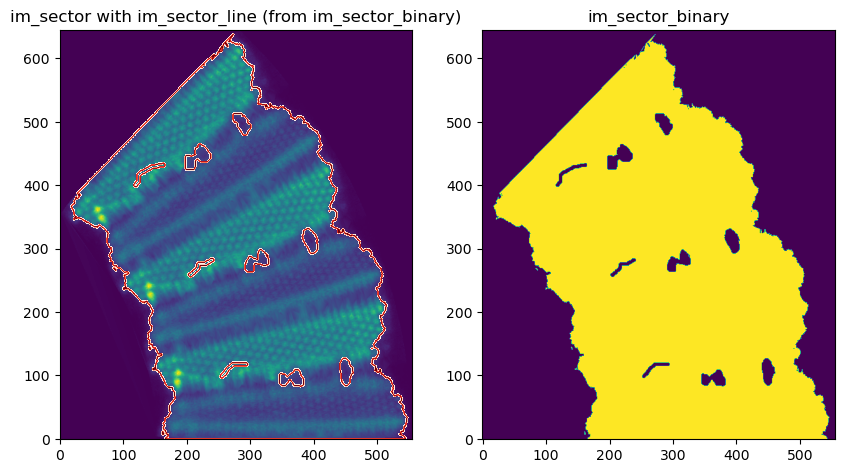

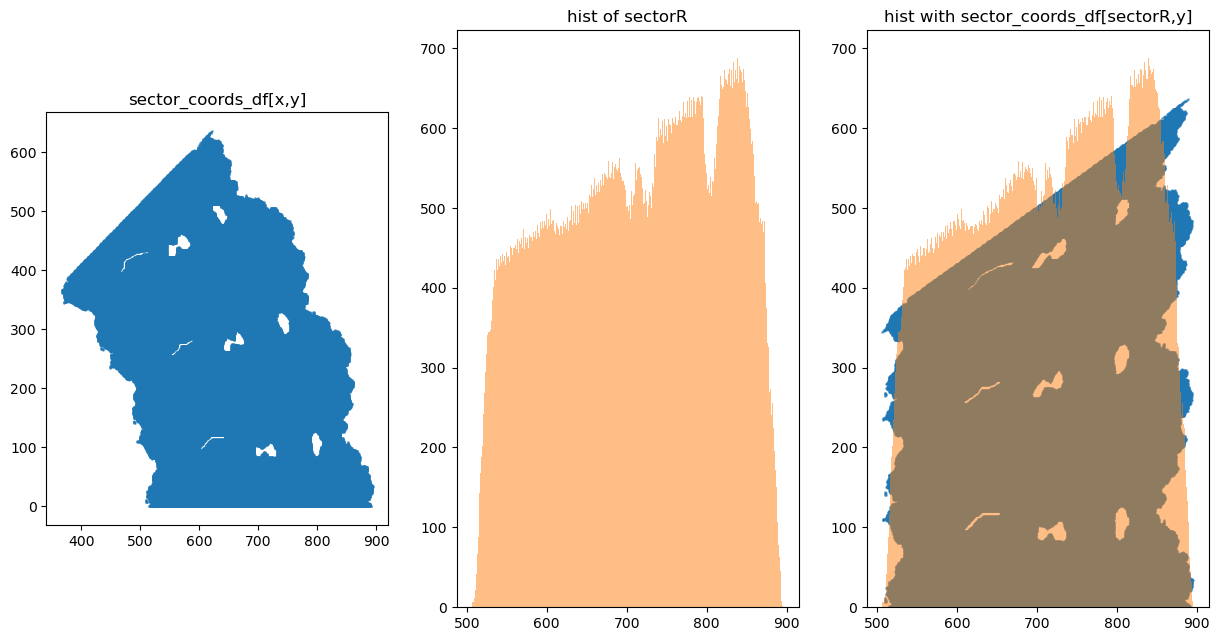

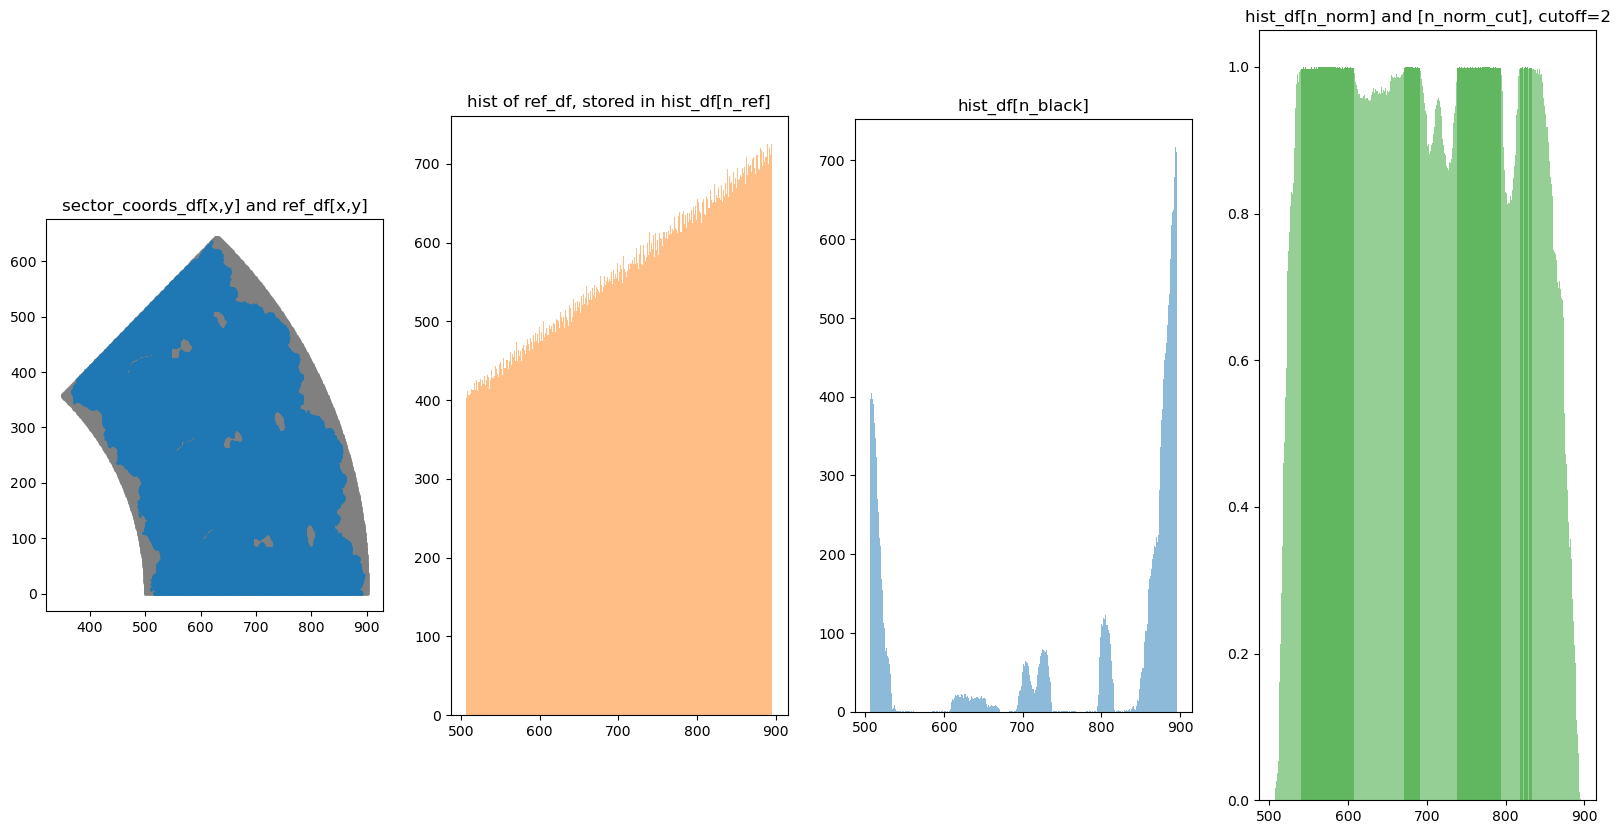

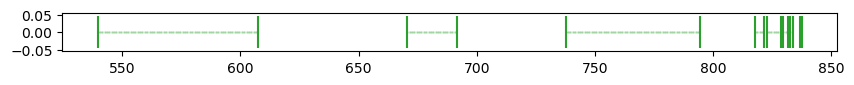

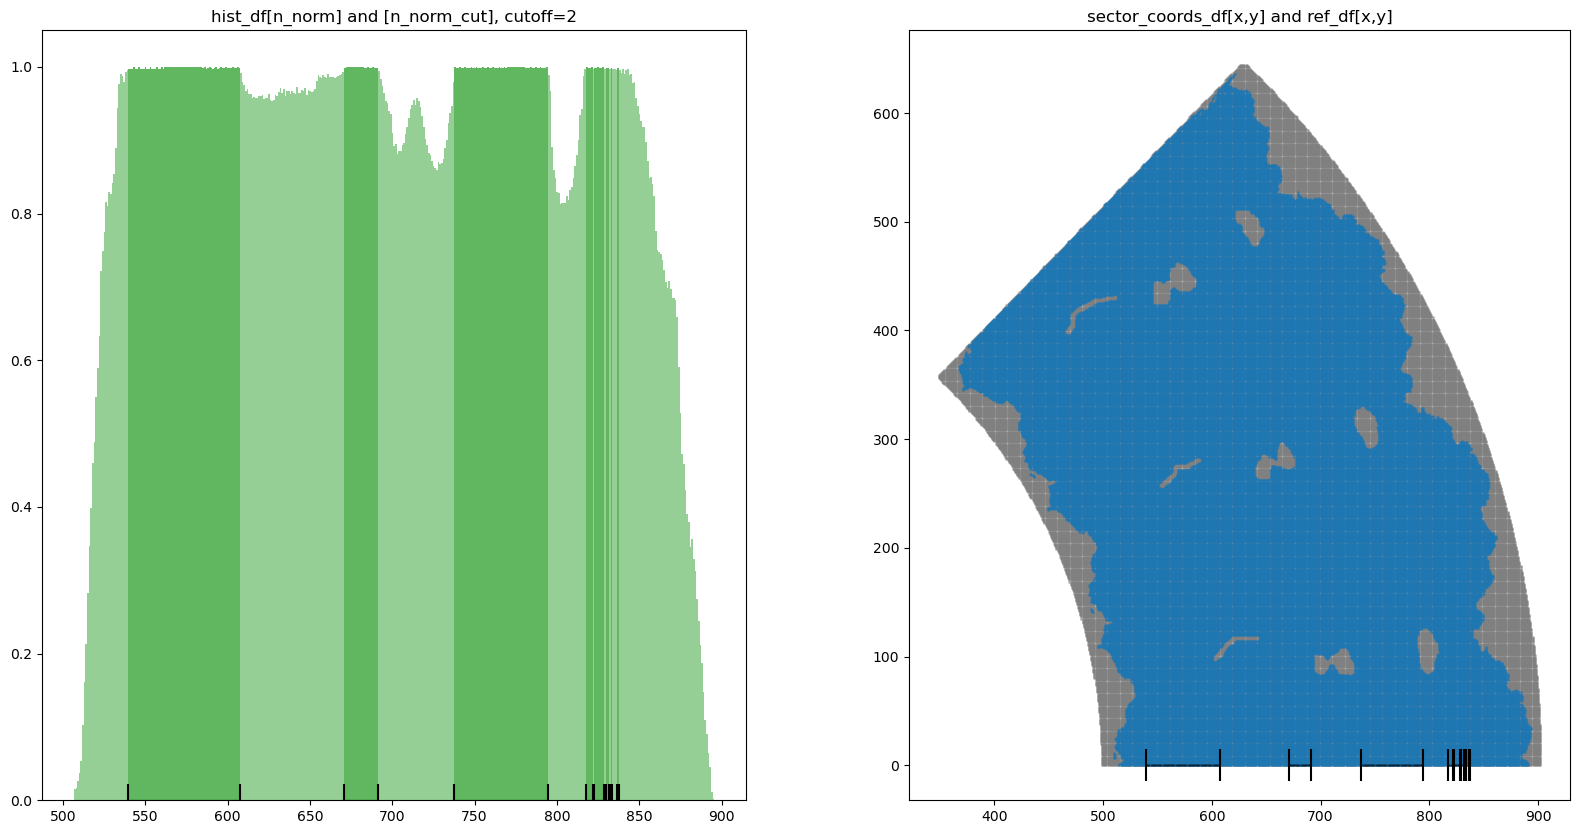

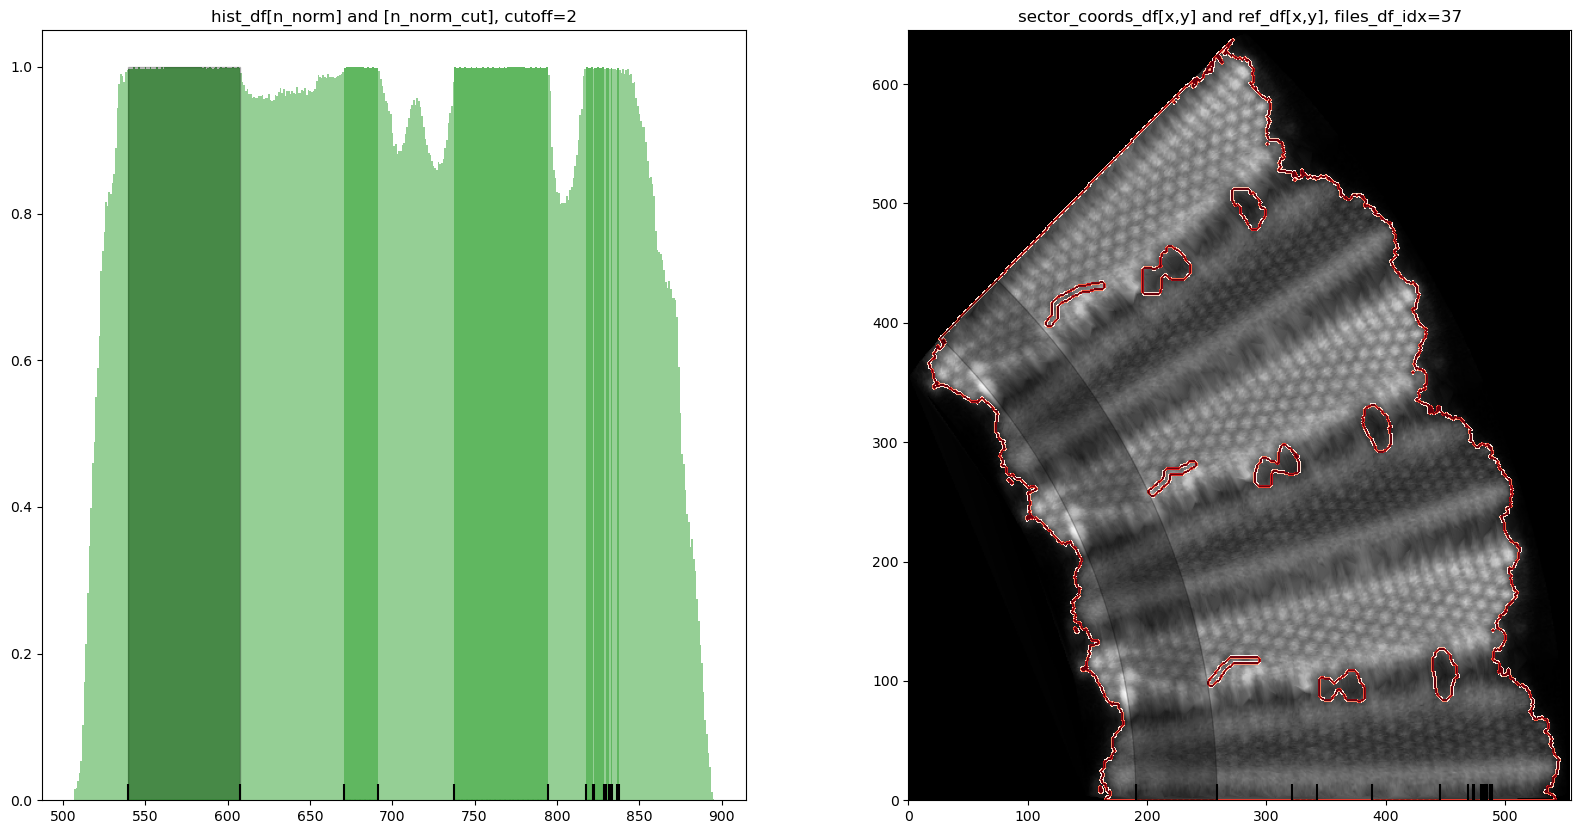

In [39]:
# for files_df_idx in range(len(files_df)):
# print(files_df_idx)
# plt.show()

print('manually edit binary masks (/masked grains) in ImageJ (note: sync .png and .tif windows in ImageJ to help with editting). after manually masking the .tif, reimport')
im_sector=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'))

print('ensure im_sector_binary is actually binary 0 and 1, and not near-0 and near-1')
im_sector_binary=io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif')
im_sector_binary=(im_sector_binary>=10)*1 #sometimes i accidentally select a nonzero value that looks white..
io.imsave(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif',(255*im_sector_binary/np.max(im_sector_binary)).astype(np.uint8)) 
im_sector_binary=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif'))    

print('crop im_sector_binary to desired region, since we probably over-masked the edges')
ref_df=pd.DataFrame({'x':np.where(im_sector>=0)[1]-origin_x,'y':np.where(im_sector>=0)[0]-origin_y})
ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))

im_temp_df=ref_df[(ref_df['phi']>=0*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<3*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #sectorR_min and max were detected from unmodified data during cone fitting

origin_x=files_df.iloc[files_df_idx]['origin_x']
origin_y=files_df.iloc[files_df_idx]['origin_y']
im_temp_binary=np.zeros(np.shape(im_sector))
for im_temp_idx in range(len(im_temp_df)):
    x=int(im_temp_df.iloc[im_temp_idx]['x']+origin_x)
    y=int(im_temp_df.iloc[im_temp_idx]['y']+origin_y)
    im_temp_binary[y,x]=1
im_sector_binary=im_sector_binary*im_temp_binary #mask out extraneous pixels, only keep pixels within specified bounds
im_sector_line=binary_dilation(im_sector_binary)*1-binary_erosion(im_sector_binary)*1

custom_cmap=plt.get_cmap('Reds')(range(256)) #256 colors in colormap
custom_cmap[0][-1]=0

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(121)
ax.imshow(im_sector,origin='lower')
ax.imshow(im_sector_line,cmap=ListedColormap(custom_cmap),origin='lower')
ax.set_title('im_sector with im_sector_line (from im_sector_binary)')

ax=fig.add_subplot(122)
ax.imshow(im_sector_binary,origin='lower')
ax.set_title('im_sector_binary')

origin_x=files_df.iloc[files_df_idx]['origin_x'] #we have to shift by this value everytime we're going from coordinates to image or vice versa
origin_y=files_df.iloc[files_df_idx]['origin_y']

print('convert im_sector_binary to sector_coords_df')
sector_coords_df=pd.DataFrame({'x':np.where(im_sector_binary>0)[1]-origin_x,'y':np.where(im_sector_binary>0)[0]-origin_y})
sector_coords_df['sectorR']=np.sqrt(sector_coords_df['x']**2+sector_coords_df['y']**2)
sector_coords_df['phi']=np.rad2deg(np.arctan2(sector_coords_df['y'],sector_coords_df['x']))

print('since im_sector_binary likely contains extraneous white area, crop to reference region')
ref_df=pd.DataFrame({'x':np.where(im_sector_binary>=0)[1]-origin_x,'y':np.where(im_sector_binary>=0)[0]-origin_y})
ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))

ref_df=ref_df[(ref_df['phi']<3*np.abs(files_df['sectorangle'].iloc[files_df_idx]))
              &(ref_df['sectorR']>=files_df['sectorR_min'].iloc[files_df_idx])
              &(ref_df['sectorR']<=files_df['sectorR_max'].iloc[files_df_idx])]

sectorR_lim=(np.min(ref_df['sectorR']),np.max(ref_df['sectorR']))
phi_lim=(np.min(ref_df['phi']),np.max(ref_df['phi']))

sector_coords_df=sector_coords_df[
    (sector_coords_df['sectorR']>=sectorR_lim[0])&(sector_coords_df['sectorR']<=sectorR_lim[1])
    &(sector_coords_df['phi']>=phi_lim[0])&(sector_coords_df['phi']<=phi_lim[1])]

hist_df=pd.DataFrame([])

print('bin sectorR values, starting from innermost sectorR value')
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(131)
ax.scatter(sector_coords_df['x'],sector_coords_df['y'],alpha=0.5,s=1)
ax.set_aspect('equal')
ax.set_title('sector_coords_df[x,y]')

ax=fig.add_subplot(132)
binwidth=1
bins=np.arange(np.min(sector_coords_df['sectorR']),np.max(sector_coords_df['sectorR'])+binwidth,binwidth)
n,bins,_=ax.hist(sector_coords_df['sectorR'],bins=bins,color='C1',alpha=0.5)
hist_df['bins']=bins[:-1]
hist_df['n']=n
hist_df['binwidth']=binwidth
ax.set_aspect('equal')
ax.set_title('hist of sectorR')

ax=fig.add_subplot(133)
ax.scatter(sector_coords_df['sectorR'],sector_coords_df['y'],alpha=0.5,s=1)
ax.bar(hist_df['bins']+binwidth/2,n,width=binwidth,alpha=0.5)
ax.set_aspect('equal')
ax.set_title('hist with sector_coords_df[sectorR,y]')

print('normalize by circumference (arclength) - max should be 1 for binwidth=1')
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(141)
ax.scatter(ref_df['x'],ref_df['y'],color='grey',alpha=0.5,s=1)
ax.scatter(sector_coords_df['x'],sector_coords_df['y'],alpha=0.5,s=1)
ax.set_aspect('equal')
ax.set_title('sector_coords_df[x,y] and ref_df[x,y]')

ax=fig.add_subplot(142)
bins=np.arange(np.min(sector_coords_df['sectorR']),np.max(sector_coords_df['sectorR'])+binwidth,binwidth)
n,bins,_=ax.hist(ref_df['sectorR'],bins=bins,color='C1',alpha=0.5)
hist_df['n_ref']=n

ax.set_aspect('equal')
ax.set_title('hist of ref_df, stored in hist_df[n_ref]')

ax=fig.add_subplot(143)
hist_df['n_black']=hist_df['n_ref']-hist_df['n']
ax.bar(hist_df['bins']+binwidth/2,hist_df['n_black'],width=binwidth,alpha=0.5)
ax.set_aspect('equal')
ax.set_title('hist_df[n_black]')

print('find domain edges of n_norm_cut, above cutoff. we want to determine threshold values to use np.digitize')    
# cutoff=0.95
cutoff=2 #defect pixel threshold used for hist_df['n_black']. defect if >=cutoff, grain if <cutoff.
ax=fig.add_subplot(144)
hist_df['n_norm']=hist_df['n']/hist_df['n_ref'] #we normalize for visualization purposes (easier to compare across diff cone angles)
hist_df['n_norm_cut']=hist_df[hist_df['n_black']<cutoff]['n_norm'] #only consider df row if doesn't contain defect
# hist_df['n_norm_cut']=hist_df[hist_df['n_norm']>cutoff]['n_norm']
# ax.scatter(sector_coords_df['sectorR'],sector_coords_df['y'],alpha=0.5,s=1)
ax.bar(bins[:-1]+binwidth/2,hist_df['n_norm'],width=binwidth,alpha=0.5,color='C2')

ax.bar(bins[:-1]+binwidth/2,hist_df['n_norm_cut'],width=binwidth,alpha=0.5,color='C2')
# ax.set_aspect('equal')
ax.set_title('hist_df[n_norm] and [n_norm_cut], cutoff='+str(cutoff))

#remember that bins represents the left edge only
fig=plt.figure(figsize=(10,0.5))
ax=fig.add_subplot(111)
x=hist_df[hist_df['n_norm_cut'].notnull()]['bins']
y=np.zeros(len(x))
coords=list(zip(x,y)) #represent each slice of the band as a particle. we want to find outermost particles for each band domain
ax.scatter(x,y,s=1,color='C2',alpha=0.25)

print('this is a nearest neighbor problem. domain edges have only 1 neighbor, domain interior particles have 2 neighbors.')
if coords!=[]: #if there are bands
    dist_df=pd.DataFrame(cdist(coords,coords))
    adj_df=dist_df[dist_df<=binwidth+0.001]
    thresh_list=[]
    for coords_idx in range(len(coords)): #for each value of hist_df['n_norm_cut']['bins']
        x=coords[coords_idx][0]    
        nearest_num=np.sum(adj_df.iloc[coords_idx]) #find number of immediately neighboring bins
        if nearest_num==0: #domain width of 1 binwidth
            bin_left=x-0.0001
            bin_right=x+binwidth+0.0001
            thresh_list+=[bin_left,bin_right]        
            print(bin_left,bin_right)
        if nearest_num==1: #domain edge! determine if left or right boundary. if right boundary, we need to add binwidth to find proper threshold value.
            coords_nearest=coords[(np.where(adj_df.iloc[coords_idx]==1)[0])[0]][0] 
            if x<coords_nearest: #if bin value only has neighboring bins on right side...
                bin_left=x-0.001 #we found the left edge of the domain!
                thresh_list+=[bin_left]
            if coords_nearest<x: #same goes for other side
                bin_right=x+binwidth+0.001
                thresh_list+=[bin_right]            
        #we skip the case for nearest_num==2 since those are domain interior values

    ax.scatter(thresh_list,np.zeros(len(thresh_list)),s=500,marker='|',color='C2')

    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(121)

    # hist_df['n_norm']=hist_df['n']/hist_df['n_ref']
    # hist_df['n_norm_cut']=hist_df[hist_df['n_norm']>cutoff]['n_norm']
    # ax.scatter(sector_coords_df['sectorR'],sector_coords_df['y'],alpha=0.5,s=1)
    ax.bar(bins[:-1]+binwidth/2,hist_df['n_norm'],width=binwidth,alpha=0.5,color='C2')

    ax.bar(bins[:-1]+binwidth/2,hist_df['n_norm_cut'],width=binwidth,alpha=0.5,color='C2')
    # ax.set_aspect('equal')
    ax.set_title('hist_df[n_norm] and [n_norm_cut], cutoff='+str(cutoff))
    ax.scatter(hist_df[hist_df['n_norm_cut'].notnull()]['bins'],np.zeros(len(hist_df[hist_df['n_norm_cut'].notnull()]['bins'])),s=1,color='C2',alpha=0.25)
    ax.scatter(thresh_list,np.zeros(len(thresh_list)),s=500,marker='|',color='k')

    ax=fig.add_subplot(122)
    ax.scatter(ref_df['x'],ref_df['y'],color='grey',alpha=0.5,s=1)
    ax.scatter(sector_coords_df['x'],sector_coords_df['y'],alpha=0.5,s=1)
    ax.set_aspect('equal')
    ax.set_title('sector_coords_df[x,y] and ref_df[x,y]')

    ax.scatter(hist_df[hist_df['n_norm_cut'].notnull()]['bins'],np.zeros(len(hist_df[hist_df['n_norm_cut'].notnull()]['bins'])),s=1,color='k',alpha=0.25)
    ax.scatter(thresh_list,np.zeros(len(thresh_list)),s=500,marker='|',color='k')

    print('group the bins together into bands and find the width and area of each band')
    hist_df['band_label']=np.digitize(hist_df['bins'], thresh_list)+1#avoid confusion during filtering, so start from 1
    hist_df['band_label_cut']=hist_df['n_norm_cut'].notnull()*hist_df['band_label'] #only consider bins above the cut value

    bands_df=pd.DataFrame([])
    bands_df['band_label_cut']=np.unique(hist_df[hist_df['band_label_cut']>0]['band_label_cut'])

    band_width_list=[]
    sectorR_min_list=[]
    sectorR_max_list=[]
    sectorR_0_list=[]
    band_area_list=[]
    band_area_ref_list=[]
    for band_idx in range(len(bands_df)):
        band_label_cut=bands_df.iloc[band_idx]['band_label_cut']
        filtered=hist_df[hist_df['band_label_cut']==band_label_cut]
        binwidth=np.unique(filtered['binwidth'])[0]
        band_width=len(filtered)*binwidth
        sectorR_min=np.min(filtered['bins']) #sectorR is aligned with x-axis. bins represents left edge
        sectorR_max=np.max(filtered['bins'])+binwidth #get right edge of max bin
        sectorR_0=(sectorR_min+sectorR_max)/2
        band_area=np.sum(filtered['n'])
        band_area_ref=np.sum(filtered['n_ref'])

        band_width_list+=[band_width]
        sectorR_min_list+=[sectorR_min]
        sectorR_max_list+=[sectorR_max]
        sectorR_0_list+=[sectorR_0]    
        band_area_list+=[band_area]
        band_area_ref_list+=[band_area_ref]

    bands_df['band_width']=band_width_list
    bands_df['sectorR_min']=sectorR_min_list
    bands_df['sectorR_max']=sectorR_max_list
    bands_df['sectorR_0']=sectorR_0_list
    bands_df['band_area']=band_area_list
    bands_df['band_area_ref']=band_area_ref_list
    
    print('store info about the widest band')
    max_band=bands_df.sort_values(by='band_width',ascending=False).iloc[[0]]
    files_df.at[files_df_idx,'band_width']=max_band['band_width'].values
    files_df.at[files_df_idx,'band_sectorR_min']=max_band['sectorR_min'].values
    files_df.at[files_df_idx,'band_sectorR_max']=max_band['sectorR_max'].values
    files_df.at[files_df_idx,'band_sectorR_0']=max_band['sectorR_0'].values
    files_df.at[files_df_idx,'band_area']=max_band['band_area'].values
    files_df.at[files_df_idx,'band_area_ref']=max_band['band_area_ref'].values
    files_df.at[files_df_idx,'band_circ_0']=max_band['sectorR_0'].values*np.abs(np.deg2rad(files_df.iloc[files_df_idx]['sectorangle']))    
    files_df.at[files_df_idx,'band_diam_0']=max_band['sectorR_0'].values*np.abs(np.deg2rad(files_df.iloc[files_df_idx]['sectorangle']))/np.pi
else:
    thresh_list=[]
    files_df.at[files_df_idx,'band_width']=0
    files_df.at[files_df_idx,'band_sectorR_min']=files_df.iloc[files_df_idx]['sectorR_min']
    files_df.at[files_df_idx,'band_sectorR_max']=files_df.iloc[files_df_idx]['sectorR_max']
    files_df.at[files_df_idx,'band_sectorR_0']=(files_df.iloc[files_df_idx]['sectorR_min']+files_df.iloc[files_df_idx]['sectorR_max'])/2
    files_df.at[files_df_idx,'band_area']=0
    files_df.at[files_df_idx,'band_area_ref']=0
    files_df.at[files_df_idx,'band_circ_0']=files_df.iloc[files_df_idx]['band_sectorR_0']*np.abs(np.deg2rad(files_df.iloc[files_df_idx]['sectorangle']))    
    files_df.at[files_df_idx,'band_diam_0']=files_df.iloc[files_df_idx]['band_sectorR_0']*np.abs(np.deg2rad(files_df.iloc[files_df_idx]['sectorangle']))/np.pi
    
print('\nexport files_df to store data info')
files_df.to_pickle(dir_path+'files_df.pkl');
files_df.to_excel(dir_path+'/files_df.xlsx')

files_df.iloc[[files_df_idx]]

print('export summary image in /bands')
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(121)
# hist_df['n_norm']=hist_df['n']/hist_df['n_ref']
# hist_df['n_norm_cut']=hist_df[hist_df['n_norm']>cutoff]['n_norm']
# ax.scatter(sector_coords_df['sectorR'],sector_coords_df['y'],alpha=0.5,s=1)
ax.bar(bins[:-1]+binwidth/2,hist_df['n_norm'],width=binwidth,alpha=0.5,color='C2')
ax.bar(bins[:-1]+binwidth/2,hist_df['n_norm_cut'],width=binwidth,alpha=0.5,color='C2')
xy=(files_df.iloc[files_df_idx]['band_sectorR_min'],0)
width=files_df.iloc[files_df_idx]['band_width']
height=1
patch=patches.Rectangle(xy, width, height,alpha=0.25,color='black')
ax.add_patch(patch)
# ax.set_aspect('equal')
ax.set_title('hist_df[n_norm] and [n_norm_cut], cutoff='+str(cutoff))
ax.scatter(hist_df[hist_df['n_norm_cut'].notnull()]['bins'],np.zeros(len(hist_df[hist_df['n_norm_cut'].notnull()]['bins'])),s=1,color='C2',alpha=0.25)
ax.scatter(thresh_list,np.zeros(len(thresh_list)),s=500,marker='|',color='k')

ax=fig.add_subplot(122)
ax.imshow(im_sector,cmap='Greys_r',origin='lower')
ax.imshow(im_sector_line,cmap=ListedColormap(custom_cmap),origin='lower')
ax.set_title('im_sector with im_sector_line (from im_sector_binary)')

# ax.imshow(im_sector_binary,origin='lower')
# ax.set_title('im_sector_binary')

# ax.scatter(ref_df['x']+origin_y,ref_df['y']+origin_y,color='grey',alpha=0.1,s=1)
# ax.scatter(sector_coords_df['x']+origin_y,sector_coords_df['y']+origin_y,alpha=0.5,s=1)
ax.set_aspect('equal')
ax.set_title('sector_coords_df[x,y] and ref_df[x,y], files_df_idx='+str(files_df_idx))

ax.scatter(origin_x+hist_df[hist_df['n_norm_cut'].notnull()]['bins'],origin_y+np.zeros(len(hist_df[hist_df['n_norm_cut'].notnull()]['bins'])),s=1,color='k',alpha=0.25)
ax.scatter(origin_x+thresh_list,origin_y+np.zeros(len(thresh_list)),s=500,marker='|',color='k')

center=(origin_x,origin_y)
r=files_df.iloc[files_df_idx]['band_sectorR_max']
theta1=0
theta2=files_df.iloc[files_df_idx]['sectorangle']*3
width=files_df.iloc[files_df_idx]['band_width']
patch=patches.Wedge(center, r, theta1, theta2, width=width,color='k',alpha=0.25)
ax.add_patch(patch)
ax.set_xlim(0,np.shape(im_sector)[1])
ax.set_ylim(0,np.shape(im_sector)[0])
print('save /bands')
if not os.path.exists(dir_path+'/all grains/bands'):
    os.mkdir(dir_path+'/all grains/bands')
im_path=dir_path+'/all grains/bands/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
# io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
plt.savefig(im_path,bbox_inches='tight', pad_inches=0)

print('note: if output is empty-ish its probably because band width was detected to be 0, which messes with ax limits.')
print('in addition, if norm exceeds 1, its likely due to manual masking at the top edge, above the topmost periodic boundary.')

save just the banded im
save /bands
note: if output is empty-ish its probably because band width was detected to be 0, which messes with ax limits.
in addition, if norm exceeds 1, its likely due to manual masking at the top edge, above the topmost periodic boundary.


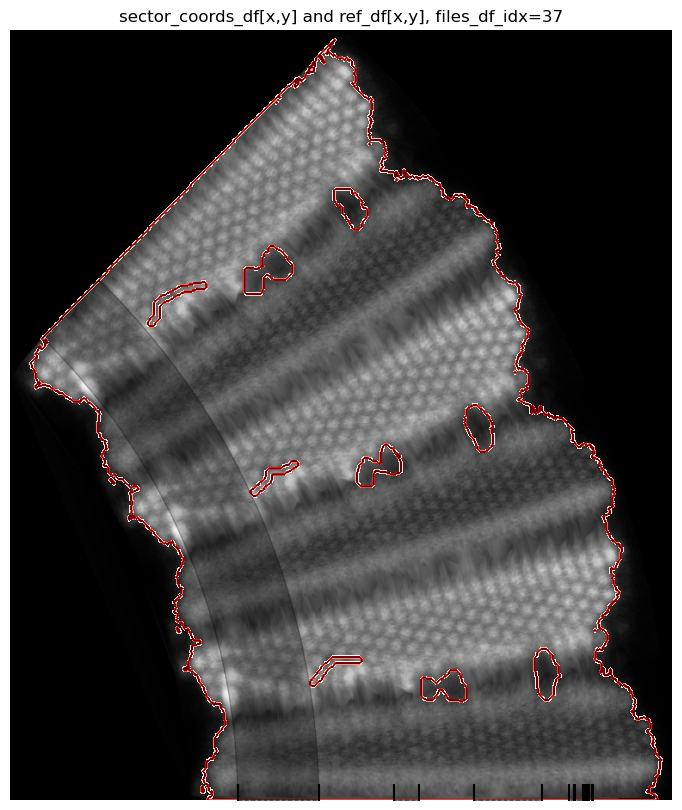

In [40]:
print('save just the banded im')
fig,ax=plt.subplots(1,figsize=(10,10))
ax.imshow(im_sector,cmap='Greys_r',origin='lower')
ax.imshow(im_sector_line,cmap=ListedColormap(custom_cmap),origin='lower')
ax.set_title('im_sector with im_sector_line (from im_sector_binary)')

ax.axis('off')

# ax.imshow(im_sector_binary,origin='lower')
# ax.set_title('im_sector_binary')

# ax.scatter(ref_df['x']+origin_y,ref_df['y']+origin_y,color='grey',alpha=0.1,s=1)
# ax.scatter(sector_coords_df['x']+origin_y,sector_coords_df['y']+origin_y,alpha=0.5,s=1)
ax.set_aspect('equal')
ax.set_title('sector_coords_df[x,y] and ref_df[x,y], files_df_idx='+str(files_df_idx))

ax.scatter(origin_x+hist_df[hist_df['n_norm_cut'].notnull()]['bins'],origin_y+np.zeros(len(hist_df[hist_df['n_norm_cut'].notnull()]['bins'])),s=1,color='k',alpha=0.25)
ax.scatter(origin_x+thresh_list,origin_y+np.zeros(len(thresh_list)),s=500,marker='|',color='k')

center=(origin_x,origin_y)
r=files_df.iloc[files_df_idx]['band_sectorR_max']
theta1=0
theta2=files_df.iloc[files_df_idx]['sectorangle']*3
width=files_df.iloc[files_df_idx]['band_width']
patch=patches.Wedge(center, r, theta1, theta2, width=width,color='k',alpha=0.25)
ax.add_patch(patch)
ax.set_xlim(0,np.shape(im_sector)[1])
ax.set_ylim(0,np.shape(im_sector)[0])
print('save /bands')
if not os.path.exists(dir_path+'/all grains/bands/ref'):
    os.mkdir(dir_path+'/all grains/bands/ref')
im_path_svg=dir_path+'/all grains/bands/ref/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.svg'
im_path_png=dir_path+'/all grains/bands/ref/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
# io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
plt.savefig(im_path_svg,bbox_inches='tight', pad_inches=0)

extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(im_path_png, bbox_inches=extent)

print('note: if output is empty-ish its probably because band width was detected to be 0, which messes with ax limits.')
print('in addition, if norm exceeds 1, its likely due to manual masking at the top edge, above the topmost periodic boundary.')

find im_top and im_bot using unwrapped image
find grain orientation
sharpen im_top and im_bot to help with particle tracking
find particles


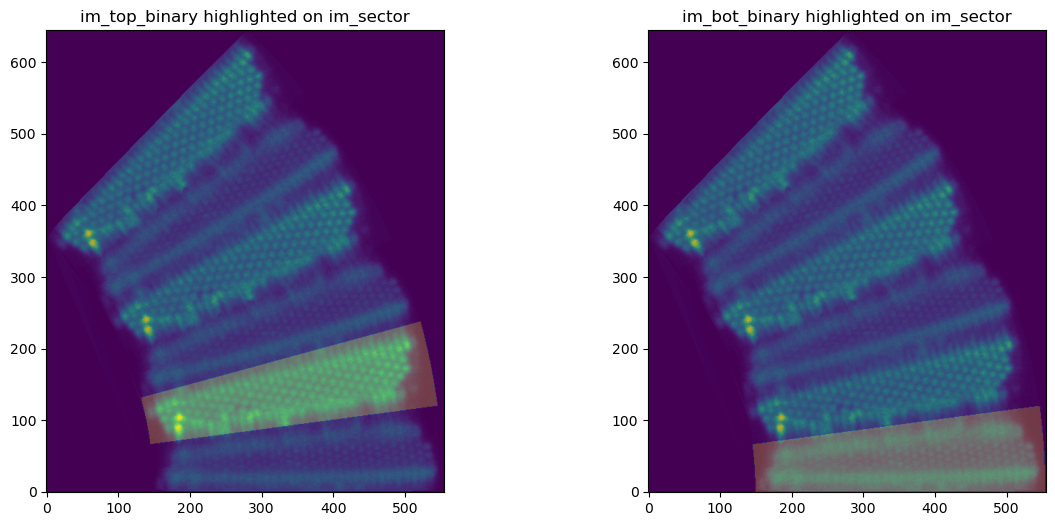

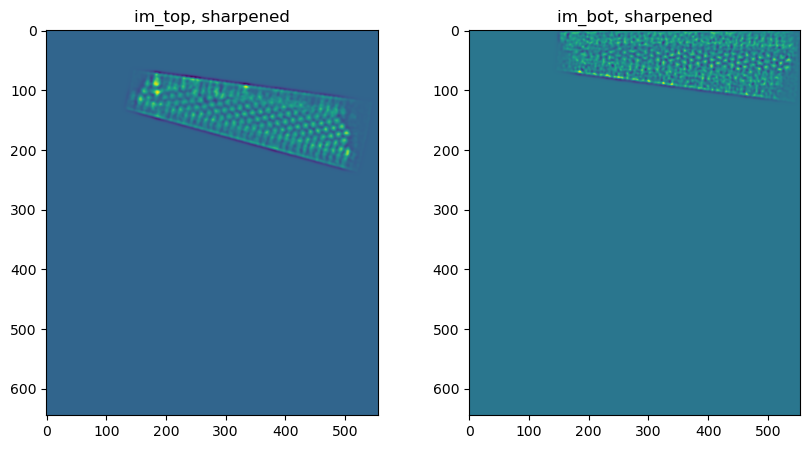

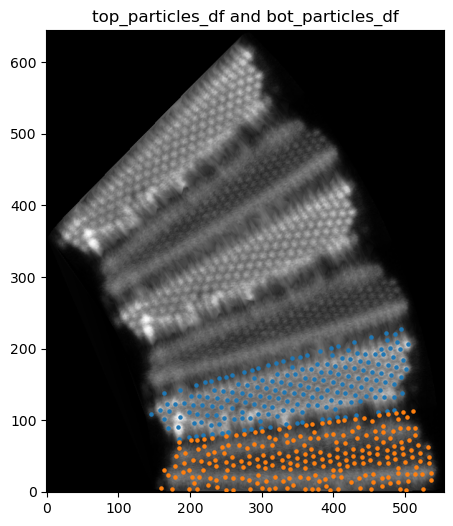

In [42]:
print('find im_top and im_bot using unwrapped image')
im_sector=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'))
im_sector_binary=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif'))

origin_x=files_df.iloc[files_df_idx]['origin_x']
origin_y=files_df.iloc[files_df_idx]['origin_y']
ref_df=pd.DataFrame({'x':np.where(im_sector>=0)[1]-origin_x,'y':np.where(im_sector>=0)[0]-origin_y})
ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))

im_top_df=ref_df[(ref_df['phi']>=0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_bot_df=ref_df[(ref_df['phi']>=0*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant

origin_x=files_df.iloc[files_df_idx]['origin_x']
origin_y=files_df.iloc[files_df_idx]['origin_y']
im_top_binary=np.zeros(np.shape(im_sector))
for im_top_idx in range(len(im_top_df)):
    x=int(im_top_df.iloc[im_top_idx]['x']+origin_x)
    y=int(im_top_df.iloc[im_top_idx]['y']+origin_y)
    im_top_binary[y,x]=1
im_bot_binary=np.zeros(np.shape(im_sector))
for im_bot_idx in range(len(im_bot_df)):
    x=int(im_bot_df.iloc[im_bot_idx]['x']+origin_x)
    y=int(im_bot_df.iloc[im_bot_idx]['y']+origin_y)
    im_bot_binary[y,x]=1
    
fig=plt.figure(figsize=(figsize_dim[0]*3,figsize_dim[1]))
ax=fig.add_subplot(121)
ax.imshow(im_sector,origin='lower',alpha=1)
ax.imshow(im_top_binary,origin='lower',alpha=0.25)
ax.set_title('im_top_binary highlighted on im_sector')

ax=fig.add_subplot(122)
ax.imshow(im_sector,origin='lower',alpha=1)
ax.imshow(im_bot_binary,origin='lower',alpha=0.25)
ax.set_title('im_bot_binary highlighted on im_sector')

print('find grain orientation')
im_top=im_top_binary*im_sector

im_bot=exposure.equalize_adapthist(im_bot_binary.astype('bool')*im_sector,kernel_size=(5,5))

print('sharpen im_top and im_bot to help with particle tracking')
fig=plt.figure(figsize=(10,5))
f = im_top
blurred_f = gaussian_filter(f, 2)
filter_blurred_f = gaussian_filter(blurred_f, 1)
alpha = 100
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f) #unsharp masking ('linear sharpening')
im_top=sharpened
ax=fig.add_subplot(121)
ax.imshow(im_top)
ax.set_title('im_top, sharpened')

f = im_bot
blurred_f = gaussian_filter(f, 2)
filter_blurred_f = gaussian_filter(blurred_f, 1)
alpha = 100
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f) #unsharp masking ('linear sharpening')
im_bot=sharpened
ax=fig.add_subplot(122)
ax.imshow(im_bot)
ax.set_title('im_bot, sharpened')

print('find particles')
fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]))
ax=fig.add_subplot(121)
top_particles_df=tp.locate(im_top*im_top_binary,diameter=7,preprocess=False)
top_particles_df['pos']=list(zip(top_particles_df['x'],top_particles_df['y']))
ax.scatter(top_particles_df['x'],top_particles_df['y'],s=5)

bot_particles_df=tp.locate(im_bot*im_bot_binary,diameter=7,preprocess=False) #characterize=False,
# bot_particles_df=bot_particles_df[bot_particles_df['ecc']<0.1].reset_index(drop=True) #don't consider large&bright particles
bot_particles_df['pos']=list(zip(bot_particles_df['x'],bot_particles_df['y']))
ax.scatter(bot_particles_df['x'],bot_particles_df['y'],s=5)

ax.imshow(im_sector,cmap='Greys_r',alpha=1,origin='lower')
ax.set_title('top_particles_df and bot_particles_df')

plt.show()

store particle positions as graph nodes
find bonds and add as edges to graph
find bond orientation for a given bond and set as edge attribute
find ij_angle_avg (avg angle of all bonds) and set as graph attribute
find local orientation node_ij_avg (theta6 value at each node) and set as node attribute
find edge_colors for visualization
find node_colors as visualization
draw graph nodes and edges
orientation histogram for visualization
colorbar for visualization

export files_df to store data info


date   cone              pullparams  \
37  080723  cone3  tw100_h453_p45_v30_t10   

                              file_name  \
37  080723_cone3_Combined Stacks1-1.tif   

                                            file_path  coneangle  line1angle  \
37  /Users/jessicasun/Desktop/research files/cones...   4.864348    2.477704   

    line2angle  line1slope  line2slope  ...  origin_y  band_width  \
37   -2.386644    0.043271   -0.041679  ...      -0.0        68.0   

    band_sectorR_min  band_sectorR_max  band_sectorR_0  band_area  \
37        539.622147        607.622147      573.622147    31202.0   

    band_area_ref  band_circ_0  band_diam_0  band_label_cut  
37        31234.0   152.949234    48.685253             NaN  

[1 rows x 45 columns]

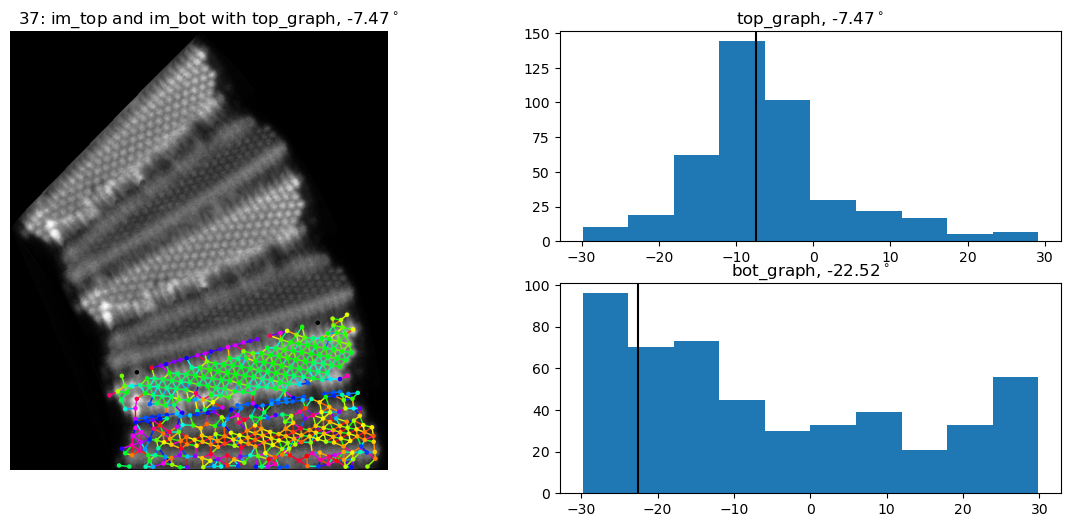

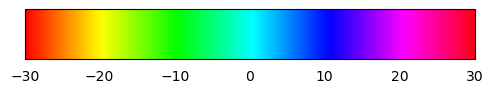

In [44]:
print('store particle positions as graph nodes')
top_graph=nx.Graph()
node_list=[]
for node_idx in range(len(top_particles_df)):
    node_list+=[(node_idx,top_particles_df.T.to_dict()[node_idx])]
top_graph.add_nodes_from(node_list)

bot_graph=nx.Graph()
node_list=[]
for node_idx in range(len(bot_particles_df)):
    node_list+=[(node_idx,bot_particles_df.T.to_dict()[node_idx])]
bot_graph.add_nodes_from(node_list)

print('find bonds and add as edges to graph')
dist_bond=17
dist_df=pd.DataFrame(cdist(top_particles_df[['x','y']],top_particles_df[['x','y']]))
adj_matrix=dist_df[dist_df<dist_bond]>0 #adjacency matrix representing bonds between particle indices
edge_list=list(zip(np.where(adj_matrix)[0],np.where(adj_matrix)[1]))
top_graph.add_edges_from(edge_list)

dist_df=pd.DataFrame(cdist(bot_particles_df[['x','y']],bot_particles_df[['x','y']]))
adj_matrix=dist_df[dist_df<dist_bond]>0 #adjacency matrix representing bonds between particle indices
edge_list=list(zip(np.where(adj_matrix)[0],np.where(adj_matrix)[1]))
bot_graph.add_edges_from(edge_list)

print('find bond orientation for a given bond and set as edge attribute')
for edge in list(top_graph.edges):
    node_i,node_j=edge
    i_pos,j_pos=top_graph.nodes[node_i]['pos'],top_graph.nodes[node_j]['pos']    
    ij_angle=np.array((np.arctan2(i_pos[1]-j_pos[1],i_pos[0]-j_pos[0])*180/np.pi)%60) #convert to np array so that it's indexable (next line)
    ij_angle[ij_angle>30] -= 60 #shift from [0,60] to [-30,30]
    top_graph.edges[node_i,node_j]['ij_angle']=float(ij_angle) #store as float
for edge in list(bot_graph.edges):
    node_i,node_j=edge
    i_pos,j_pos=bot_graph.nodes[node_i]['pos'],bot_graph.nodes[node_j]['pos']    
    ij_angle=np.array((np.arctan2(i_pos[1]-j_pos[1],i_pos[0]-j_pos[0])*180/np.pi)%60) #convert to np array so that it's indexable (next line)
    ij_angle[ij_angle>30] -= 60 #shift from [0,60] to [-30,30]    
    bot_graph.edges[node_i,node_j]['ij_angle']=float(ij_angle) #store as float

print('find ij_angle_avg (avg angle of all bonds) and set as graph attribute')
top_edge_df=nx.to_pandas_edgelist(top_graph)
ij_angle_avg=np.rad2deg(circmean(np.deg2rad(top_edge_df['ij_angle']),high=30*np.pi/180, low=-30*np.pi/180))
top_graph.graph['ij_angle_avg']=ij_angle_avg

bot_edge_df=nx.to_pandas_edgelist(bot_graph)
ij_angle_avg=np.rad2deg(circmean(np.deg2rad(bot_edge_df['ij_angle']),high=30*np.pi/180, low=-30*np.pi/180))
bot_graph.graph['ij_angle_avg']=ij_angle_avg

print('find local orientation node_ij_avg (theta6 value at each node) and set as node attribute')
edge_list=nx.to_pandas_edgelist(top_graph)
bonded_nodes=np.unique(edge_list[['source','target']]) #nodes with bonds
for node in bonded_nodes: #note: nx.graph doesn't allow duplicate edges!
    node_ij_angle=list(edge_list[edge_list['source']==node]['ij_angle'].values)+list(edge_list[edge_list['target']==node]['ij_angle'].values) #find edges associated with a given node
    node_ij_avg=np.rad2deg(circmean(np.deg2rad(np.array(node_ij_angle)),high=30*np.pi/180, low=-30*np.pi/180)) #find avg of ij_angle for the edges around a node
    top_graph.nodes[node]['node_ij_avg'] = node_ij_avg
not_bonded_nodes_top=list(set(top_graph.nodes) - set(bonded_nodes)) #nodes without bonds
for node in not_bonded_nodes_top:
    top_graph.nodes[node]['node_ij_avg'] = -100 #set as placeholder angle, otherwise error thrown later

edge_list=nx.to_pandas_edgelist(bot_graph)
bonded_nodes=np.unique(edge_list[['source','target']]) #nodes with bonds
for node in bonded_nodes: #note: nx.graph doesn't allow duplicate edges!
    node_ij_angle=list(edge_list[edge_list['source']==node]['ij_angle'].values)+list(edge_list[edge_list['target']==node]['ij_angle'].values) #find edges associated with a given node
    node_ij_avg=np.rad2deg(circmean(np.deg2rad(np.array(node_ij_angle)),high=30*np.pi/180, low=-30*np.pi/180)) #find avg of ij_angle for the edges around a node
    bot_graph.nodes[node]['node_ij_avg'] = node_ij_avg
not_bonded_nodes_bot=list(set(bot_graph.nodes) - set(bonded_nodes)) #nodes without bonds
for node in not_bonded_nodes_bot:
    bot_graph.nodes[node]['node_ij_avg'] = -100 #set as placeholder angle, otherwise error thrown later

print('find edge_colors for visualization')
edge_colors = [top_graph[u][v]['ij_angle'] for u,v in top_graph.edges()]
norm=colors.Normalize(vmin=-30,vmax=30) #normalize ij_angle values
cmap = plt.cm.hsv #convert normalized values to a RGBA color
top_edge_colors=cmap(norm(edge_colors))

edge_colors = [bot_graph[u][v]['ij_angle'] for u,v in bot_graph.edges()]
norm=colors.Normalize(vmin=-30,vmax=30) #normalize ij_angle values
cmap = plt.cm.hsv #convert normalized values to a RGBA color
bot_edge_colors=cmap(norm(edge_colors))

print('find node_colors as visualization')
node_colors= [top_graph.nodes[i]['node_ij_avg'] for i in top_graph.nodes()]
norm=colors.Normalize(vmin=-30,vmax=30) #normalize ij_angle values
cmap = plt.cm.hsv #convert normalized values to a RGBA color
top_node_colors=cmap(norm(node_colors))
for node in not_bonded_nodes_top:
    top_node_colors[node]=[0,0,0,1] #set to black

node_colors= [bot_graph.nodes[i]['node_ij_avg'] for i in bot_graph.nodes()]
norm=colors.Normalize(vmin=-30,vmax=30) #normalize ij_angle values
cmap = plt.cm.hsv #convert normalized values to a RGBA color
bot_node_colors=cmap(norm(node_colors))
for node in not_bonded_nodes_bot:
    bot_node_colors[node]=[0,0,0,1] #set to black

print('draw graph nodes and edges')
fig=plt.figure(figsize=(figsize_dim[0]*3,figsize_dim[1]))
ax=fig.add_subplot(1,2,1)
ax.imshow(im_sector,cmap='Greys_r',origin='lower')

nx.draw(top_graph,top_particles_df['pos'],ax=ax,node_size=5,edge_color=top_edge_colors,node_color=top_node_colors)
nx.draw(bot_graph,bot_particles_df['pos'],ax=ax,node_size=5,edge_color=bot_edge_colors,node_color=bot_node_colors)
ax.set_title(str(files_df_idx)+': im_top and im_bot with top_graph, '+str(round(top_graph.graph['ij_angle_avg'],2))+r'$^\circ$')

print('orientation histogram for visualization')
# fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]/2))
ax=fig.add_subplot(2,2,2)
ax.hist(nx.to_pandas_edgelist(top_graph)['ij_angle'])
ax.axvline(top_graph.graph['ij_angle_avg'],color='k')
ax.set_title('top_graph, '+str(round(top_graph.graph['ij_angle_avg'],2))+r'$^\circ$')

ax=fig.add_subplot(2,2,4)
ax.hist(nx.to_pandas_edgelist(bot_graph)['ij_angle'])
ax.axvline(bot_graph.graph['ij_angle_avg'],color='k')
ax.set_title('bot_graph, '+str(round(bot_graph.graph['ij_angle_avg'],2))+r'$^\circ$')

if not os.path.exists(dir_path+'/all grains/orientation'):
    os.mkdir(dir_path+'/all grains/orientation')
im_path=dir_path+'/all grains/orientation/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'
# io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
plt.savefig(im_path,bbox_inches='tight', pad_inches=0)

print('colorbar for visualization')
fig=plt.figure(figsize=(5,5))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax,orientation='horizontal')
plt.tick_params(bottom = False)

files_df.at[files_df_idx,'top_ij_angle_avg']=top_graph.graph['ij_angle_avg']
files_df.at[files_df_idx,'bot_ij_angle_avg']=bot_graph.graph['ij_angle_avg']

print('\nexport files_df to store data info')
files_df.to_pickle(dir_path+'files_df.pkl');
files_df.to_excel(dir_path+'/files_df.xlsx')

files_df.iloc[[files_df_idx]]

find im_top and im_bot using unwrapped image
find grain orientation
sharpen im_top and im_bot to help with particle tracking
find particles


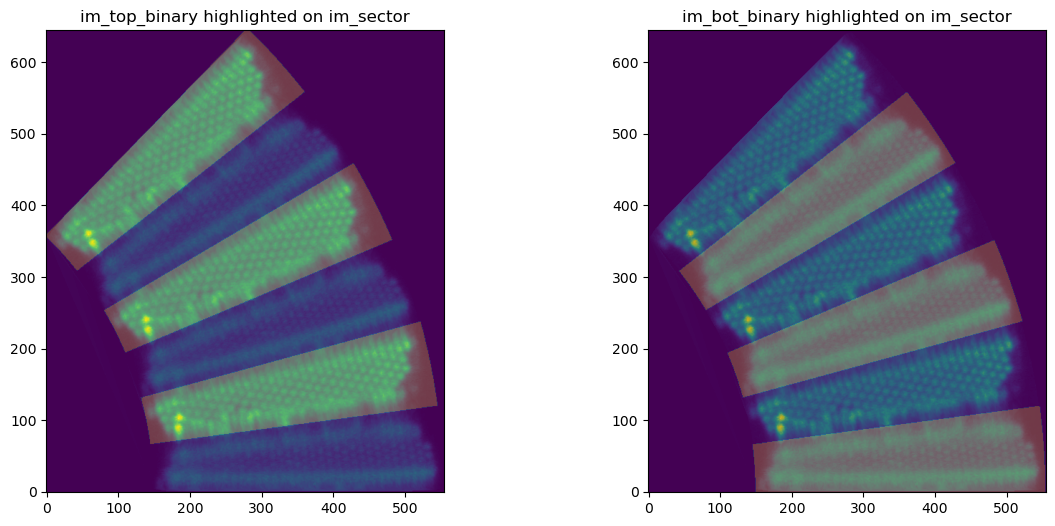

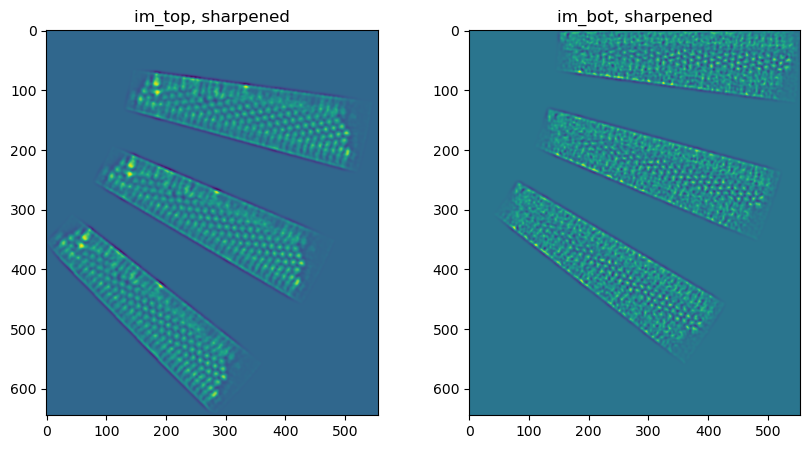

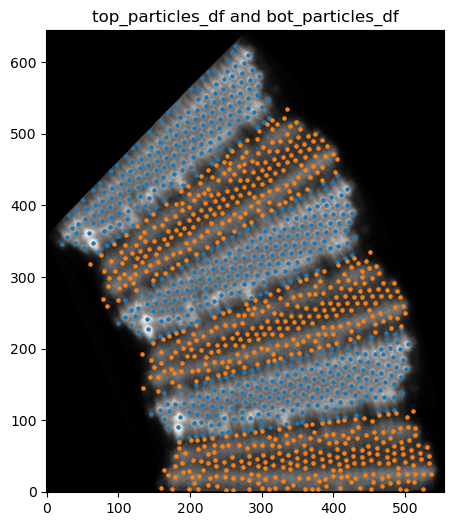

store particle positions as graph nodes
find bonds and add as edges to graph
find bond orientation for a given bond and set as edge attribute
find ij_angle_avg (avg angle of all bonds) and set as graph attribute
find local orientation node_ij_avg (theta6 value at each node), and psi6, and set as node attribute
convert to dataframe
draw graph nodes and edges
orientation histogram for visualization
colorbar for visualization

export files_df to store data info


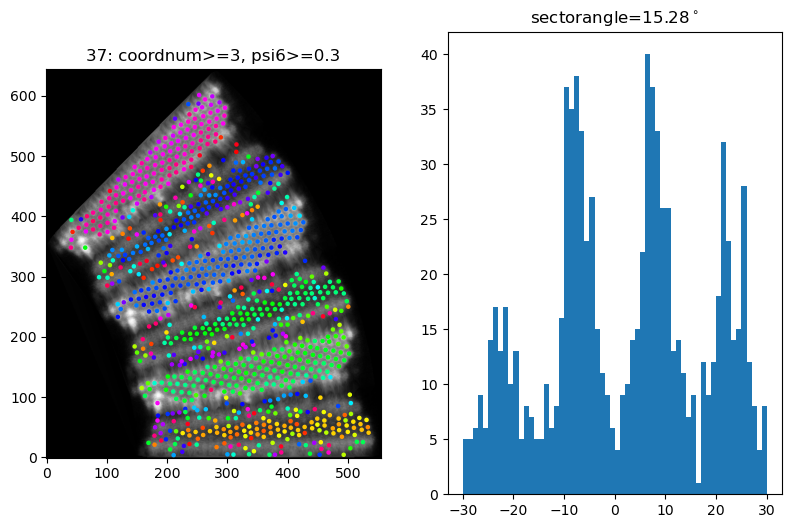

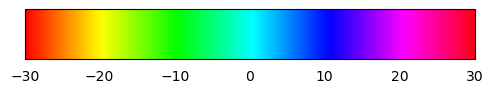

In [48]:
# full=True #takes a while to run..
full=True

# for files_df_idx in range(len(files_df)):
if full==True:
    print('find im_top and im_bot using unwrapped image')
    im_sector=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'))
    im_sector_binary=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif'))

    origin_x=files_df.iloc[files_df_idx]['origin_x']
    origin_y=files_df.iloc[files_df_idx]['origin_y']
    ref_df=pd.DataFrame({'x':np.where(im_sector>=0)[1]-origin_x,'y':np.where(im_sector>=0)[0]-origin_y})
    ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
    ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))

    im_top_df=ref_df[(ref_df['phi']>=0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
    im_top_df2=ref_df[(ref_df['phi']>=1.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<2*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
    im_top_df3=ref_df[(ref_df['phi']>=2.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<3*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
    im_top_df=pd.concat([im_top_df,im_top_df2,im_top_df3])

    im_bot_df=ref_df[(ref_df['phi']>=0*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
    im_bot_df2=ref_df[(ref_df['phi']>=1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<1.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
    im_bot_df3=ref_df[(ref_df['phi']>=2*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<2.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
    im_bot_df=pd.concat([im_bot_df,im_bot_df2,im_bot_df3])

    origin_x=files_df.iloc[files_df_idx]['origin_x']
    origin_y=files_df.iloc[files_df_idx]['origin_y']
    im_top_binary=np.zeros(np.shape(im_sector))
    for im_top_idx in range(len(im_top_df)):
        x=int(im_top_df.iloc[im_top_idx]['x']+origin_x)
        y=int(im_top_df.iloc[im_top_idx]['y']+origin_y)
        im_top_binary[y,x]=1
    im_bot_binary=np.zeros(np.shape(im_sector))
    for im_bot_idx in range(len(im_bot_df)):
        x=int(im_bot_df.iloc[im_bot_idx]['x']+origin_x)
        y=int(im_bot_df.iloc[im_bot_idx]['y']+origin_y)
        im_bot_binary[y,x]=1

    fig=plt.figure(figsize=(figsize_dim[0]*3,figsize_dim[1]))
    ax=fig.add_subplot(121)
    ax.imshow(im_sector,origin='lower',alpha=1)
    ax.imshow(im_top_binary,origin='lower',alpha=0.25)
    ax.set_title('im_top_binary highlighted on im_sector')

    ax=fig.add_subplot(122)
    ax.imshow(im_sector,origin='lower',alpha=1)
    ax.imshow(im_bot_binary,origin='lower',alpha=0.25)
    ax.set_title('im_bot_binary highlighted on im_sector')

    print('find grain orientation')
    im_top=im_top_binary*im_sector

    im_bot=exposure.equalize_adapthist(im_bot_binary.astype('bool')*im_sector,kernel_size=(5,5))

    print('sharpen im_top and im_bot to help with particle tracking')
    fig=plt.figure(figsize=(10,5))
    f = im_top
    blurred_f = gaussian_filter(f, 2)
    filter_blurred_f = gaussian_filter(blurred_f, 1)
    alpha = 100
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f) #unsharp masking ('linear sharpening')
    im_top=sharpened
    ax=fig.add_subplot(121)
    ax.imshow(im_top)
    ax.set_title('im_top, sharpened')

    f = im_bot
    blurred_f = gaussian_filter(f, 2)
    filter_blurred_f = gaussian_filter(blurred_f, 1)
    alpha = 100
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f) #unsharp masking ('linear sharpening')
    im_bot=sharpened
    ax=fig.add_subplot(122)
    ax.imshow(im_bot)
    ax.set_title('im_bot, sharpened')

    print('find particles')
    fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]))
    ax=fig.add_subplot(121)
    top_particles_df=tp.locate(im_top*im_top_binary,diameter=7,preprocess=False)
    top_particles_df['pos']=list(zip(top_particles_df['x'],top_particles_df['y']))
    ax.scatter(top_particles_df['x'],top_particles_df['y'],s=5)

    bot_particles_df=tp.locate(im_bot*im_bot_binary,diameter=7,preprocess=False) #characterize=False,
    # bot_particles_df=bot_particles_df[bot_particles_df['ecc']<0.1].reset_index(drop=True) #don't consider large&bright particles
    bot_particles_df['pos']=list(zip(bot_particles_df['x'],bot_particles_df['y']))
    ax.scatter(bot_particles_df['x'],bot_particles_df['y'],s=5)

    ax.imshow(im_sector,cmap='Greys_r',alpha=1,origin='lower')
    ax.set_title('top_particles_df and bot_particles_df')

    plt.show()

    print('store particle positions as graph nodes')
    top_graph=nx.Graph()
    node_list=[]
    for node_idx in range(len(top_particles_df)):
        node_list+=[(node_idx,top_particles_df.T.to_dict()[node_idx])]
    top_graph.add_nodes_from(node_list)

    bot_graph=nx.Graph()
    node_list=[]
    for node_idx in range(len(bot_particles_df)):
        node_list+=[(node_idx,bot_particles_df.T.to_dict()[node_idx])]
    bot_graph.add_nodes_from(node_list)

    print('find bonds and add as edges to graph')
    dist_bond=17
    dist_df=pd.DataFrame(cdist(top_particles_df[['x','y']],top_particles_df[['x','y']]))
    adj_matrix=dist_df[dist_df<dist_bond]>0 #adjacency matrix representing bonds between particle indices
    edge_list=list(zip(np.where(adj_matrix)[0],np.where(adj_matrix)[1]))
    top_graph.add_edges_from(edge_list)

    dist_df=pd.DataFrame(cdist(bot_particles_df[['x','y']],bot_particles_df[['x','y']]))
    adj_matrix=dist_df[dist_df<dist_bond]>0 #adjacency matrix representing bonds between particle indices
    edge_list=list(zip(np.where(adj_matrix)[0],np.where(adj_matrix)[1]))
    bot_graph.add_edges_from(edge_list)

    print('find bond orientation for a given bond and set as edge attribute')
    for edge in list(top_graph.edges):
        node_i,node_j=edge
        i_pos,j_pos=top_graph.nodes[node_i]['pos'],top_graph.nodes[node_j]['pos']    
        ij_angle=np.array((np.arctan2(i_pos[1]-j_pos[1],i_pos[0]-j_pos[0])*180/np.pi)%60) #convert to np array so that it's indexable (next line)
        ij_angle[ij_angle>30] -= 60 #shift from [0,60] to [-30,30]
        top_graph.edges[node_i,node_j]['ij_angle']=float(ij_angle) #store as float
    for edge in list(bot_graph.edges):
        node_i,node_j=edge
        i_pos,j_pos=bot_graph.nodes[node_i]['pos'],bot_graph.nodes[node_j]['pos']    
        ij_angle=np.array((np.arctan2(i_pos[1]-j_pos[1],i_pos[0]-j_pos[0])*180/np.pi)%60) #convert to np array so that it's indexable (next line)
        ij_angle[ij_angle>30] -= 60 #shift from [0,60] to [-30,30]    
        bot_graph.edges[node_i,node_j]['ij_angle']=float(ij_angle) #store as float

    print('find ij_angle_avg (avg angle of all bonds) and set as graph attribute')
    top_edge_df=nx.to_pandas_edgelist(top_graph)
    ij_angle_avg=np.rad2deg(circmean(np.deg2rad(top_edge_df['ij_angle']),high=30*np.pi/180, low=-30*np.pi/180))
    top_graph.graph['ij_angle_avg']=ij_angle_avg

    bot_edge_df=nx.to_pandas_edgelist(bot_graph)
    ij_angle_avg=np.rad2deg(circmean(np.deg2rad(bot_edge_df['ij_angle']),high=30*np.pi/180, low=-30*np.pi/180))
    bot_graph.graph['ij_angle_avg']=ij_angle_avg

    print('find local orientation node_ij_avg (theta6 value at each node), and psi6, and set as node attribute')
    edge_list=nx.to_pandas_edgelist(top_graph)
    bonded_nodes=np.unique(edge_list[['source','target']]) #nodes with bonds
    for node in bonded_nodes: #note: nx.graph doesn't allow duplicate edges!
        node_ij_angle=list(edge_list[edge_list['source']==node]['ij_angle'].values)+list(edge_list[edge_list['target']==node]['ij_angle'].values) #find edges associated with a given node
        psi6_list=[]
        for angle in node_ij_angle:
            psi6_list+=[np.exp(1j*6*np.deg2rad(angle))]
        coordnum=len(psi6_list)
        psi6=np.abs(np.sum(psi6_list)/coordnum) #magnitude of complex number
        node_ij_avg=np.rad2deg(circmean(np.deg2rad(np.array(node_ij_angle)),high=30*np.pi/180, low=-30*np.pi/180)) #find avg of ij_angle for the edges around a node
        top_graph.nodes[node]['node_ij_avg'] = node_ij_avg
        top_graph.nodes[node]['psi6'] = psi6    
        top_graph.nodes[node]['coordnum'] = coordnum            
    not_bonded_nodes_top=list(set(top_graph.nodes) - set(bonded_nodes)) #nodes without bonds
    for node in not_bonded_nodes_top:
        top_graph.nodes[node]['node_ij_avg'] = -100 #set as placeholder angle, otherwise error thrown later
        top_graph.nodes[node]['psi6'] = -100 #set as placeholder angle, otherwise error thrown later        
        top_graph.nodes[node]['coordnum'] = -100 #set as placeholder angle, otherwise error thrown later                

    edge_list=nx.to_pandas_edgelist(bot_graph)
    bonded_nodes=np.unique(edge_list[['source','target']]) #nodes with bonds
    for node in bonded_nodes: #note: nx.graph doesn't allow duplicate edges!
        node_ij_angle=list(edge_list[edge_list['source']==node]['ij_angle'].values)+list(edge_list[edge_list['target']==node]['ij_angle'].values) #find edges associated with a given node
        psi6_list=[]
        for angle in node_ij_angle:
            psi6_list+=[np.exp(1j*6*np.deg2rad(angle))]
        coordnum=len(psi6_list)            
        psi6=np.abs(np.sum(psi6_list)/coordnum) #magnitude of complex number        
        node_ij_avg=np.rad2deg(circmean(np.deg2rad(np.array(node_ij_angle)),high=30*np.pi/180, low=-30*np.pi/180)) #find avg of ij_angle for the edges around a node
        bot_graph.nodes[node]['node_ij_avg'] = node_ij_avg
        bot_graph.nodes[node]['psi6'] = psi6                
        bot_graph.nodes[node]['coordnum'] = coordnum                        
    not_bonded_nodes_bot=list(set(bot_graph.nodes) - set(bonded_nodes)) #nodes without bonds
    for node in not_bonded_nodes_bot:
        bot_graph.nodes[node]['node_ij_avg'] = -100 #set as placeholder angle, otherwise error thrown later
        bot_graph.nodes[node]['psi6'] = -100 #set as placeholder angle, otherwise error thrown later        
        bot_graph.nodes[node]['coordnum'] = -100 #set as placeholder angle, otherwise error thrown later                

    print('convert to dataframe')
    top_particles_df=pd.DataFrame.from_dict(top_graph.nodes, orient='index') 
    bot_particles_df=pd.DataFrame.from_dict(bot_graph.nodes, orient='index')  

    print('draw graph nodes and edges') #plot using dataframe - cant find edge colors anymore, but much simpler to filter particles
    fig=plt.figure(figsize=(figsize_dim[0]*2,figsize_dim[1]))
    ax=fig.add_subplot(121)
    ax.imshow(im_sector,cmap='Greys_r',origin='lower')

    particles_df=pd.concat([top_particles_df,bot_particles_df])
    particles_df=particles_df[(particles_df['coordnum']>=3)&(particles_df['psi6']>=0.3)]
    ax.scatter(particles_df['x'],particles_df['y'],c=particles_df['node_ij_avg'],vmin=-30,vmax=30,cmap='hsv',s=5)
    ax.set_title(str(files_df_idx)+': coordnum>=3, psi6>=0.3')

    print('orientation histogram for visualization')
    # fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]/2))
    ax=fig.add_subplot(122)
    ax.hist(particles_df['node_ij_avg'],bins=np.arange(-30,31,1))    
    # ax.hist(pd.concat([nx.to_pandas_edgelist(top_graph)['ij_angle'],nx.to_pandas_edgelist(bot_graph)['ij_angle']]),bins=np.arange(-30,30,5))
    # ax.axvline(top_graph.graph['ij_angle_avg'],color='k')
    ax.set_title('sectorangle='+str(round(files_df['sectorangle'].iloc[files_df_idx],2))+r'$^\circ$')

    if not os.path.exists(dir_path+'/all grains/orientation/full'):
        os.mkdir(dir_path+'/all grains/orientation/full')
    im_path=dir_path+'/all grains/orientation/full/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'_filtered'+'.png'
    # io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
    plt.savefig(im_path,bbox_inches='tight', pad_inches=0)

    print('colorbar for visualization')
    fig=plt.figure(figsize=(5,5))
    ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='hsv'),cax=ax,orientation='horizontal')
    plt.tick_params(bottom = False)

    files_df.at[files_df_idx,'top_ij_angle_avg']=top_graph.graph['ij_angle_avg']
    files_df.at[files_df_idx,'bot_ij_angle_avg']=bot_graph.graph['ij_angle_avg']

    print('\nexport files_df to store data info')
    files_df.to_pickle(dir_path+'files_df.pkl');
    files_df.to_excel(dir_path+'/files_df.xlsx')

    files_df.iloc[[files_df_idx]]